In [1]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
from TileEM_plot_toolbox import *
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
DATA_DIR="output"
os.chdir(DATA_DIR)

# Problem: The tiles are not exactly non-overalpping 

## Debugging BB2TileExact 

In [4]:
def overlap(a,b):
    if a.area>b.area:
        larger_area = a.area
    else:
        larger_area = b.area
    return a.intersection(b).area/larger_area

In [182]:
def compute_unique_tileset(tiles,PLOT=True):
    duplicate_count = 0
    verified_tiles = []
    duplicated=False
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        verified_tiles_new=copy.deepcopy(verified_tiles)
        for vtidx in range(len(verified_tiles)):
            vt = tiles[vtidx]
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score
                    if PLOT:
                        plt.figure()
                        plt.title("[{0},{1}]{2}".format(tidx,vtidx, overlap_score))
                        plot_coords(vt)
                        plot_coords(t,color="blue")
                    duplicated=True
                    if vt.area>t.area:
                        verified_tiles.remove(vt)
                        new_vt = vt.difference(t)
                        verified_tiles.append(new_vt)
                        verified_tiles.append(t)
                    else:
                        try:
                            verified_tiles.remove(t)
                        except(ValueError):
                            pass
                        new_t = t.difference(vt)
                        verified_tiles.append(new_t)
                        verified_tiles.append(vt)
                    duplicate_count+=1
                    
            except(shapely.geos.TopologicalError):

                print "Topological Error",tidx,vtidx
            verified_tiles=copy.deepcopy(verified_tiles_new)
        if not duplicated:
            verified_tiles.append(t)
    return  duplicated, verified_tiles

In [8]:
def compute_verfied_tiles_duplication_rate(tiles):
    duplicate_count = 0
    verified_tiles = []
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        duplicated=False
        for vtidx in range(len(verified_tiles)):
            vt = tiles[vtidx]
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score
                    duplicate_count+=1
                    duplicated=True
                    break
            except(shapely.geos.TopologicalError):
                print "Error",tidx,vtidx
        if not duplicated:
            verified_tiles.append(t)
    print "Duplication rate: ", duplicate_count/float(len(tiles))
    return verified_tiles

In [6]:
def slow_cascaded_union(tiles):
    all_tiles  = copy.deepcopy(tiles)
    Utile=tiles[0]
    all_tiles.remove(tiles[0])
    i=1
    loss_tiles = []
    while(len(all_tiles)>0):
        tile = tiles[i]
        try:
            Utile = Utile.union(tile)
        except(shapely.geos.TopologicalError):
            try:
                Utile =Utile.buffer(0).union(tile.buffer(0))
            except(shapely.geos.TopologicalError):
#                 return tile,Utile 
                #print "Throwing away:", tile.area 
                loss_tiles.append(tile)
        all_tiles.remove(tile)
        i+=1
    try:
        Utile=Utile.union(cascaded_union(loss_tiles))
    except(shapely.geos.TopologicalError):
        try:
            Utile=Utile.buffer(9e-13).union(cascaded_union(loss_tiles).buffer(0))
        except(shapely.geos.TopologicalError):
            loss_area = sum([t.area for t in loss_tiles])
            print "Throwing away:", loss_area
    return loss_tiles,Utile

In [7]:
def visualizeTilesSeparate(tiles,colorful=True):
    plt.figure()
    colors=cm.rainbow(np.linspace(0,1,len(tiles)))
    for t,i in zip(tiles,range(len(tiles))): 
#         plt.figure()
        if colorful: 
            c = colors[i]
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True,fill_color=c)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True,fill_color=c)

In [9]:
def createObjIndicatorMatrix(objid,tiles="",load_existing_tiles_from_file=False, PLOT=False,sampleNworkers=-1,random_state=111,PRINT=False,SAVE=False,EXCLUDE_BBG=True,overlap_threshold=0.8,tile_only=False,tqdm_on=False):

    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_objects = bb_info[bb_info["object_id"]==objid]
    if EXCLUDE_BBG: bb_objects =  bb_objects[bb_objects.worker_id!=3]
    # Sampling Data from Ji table 
    if sampleNworkers>0 and sampleNworkers<len(bb_objects):
        bb_objects = bb_objects.sample(n=sampleNworkers,random_state=random_state)
    # Create a list of polygons based on worker BBs 
    xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
    BB = []
    for xyloc in xylocs:
        BB.append(Polygon(xyloc).buffer(0))

    #Compute Tiles 
    if load_existing_tiles_from_file:
        tiles = pkl.load(open("{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
        #worker_lst= pkl.load(open("{0}/worker{1}.pkl".format(DATA_DIR,objid),'r'))
    elif tiles=="":
        tiles = BB2TileExact(objid,BB,tqdm_on=tqdm_on,save_tiles=SAVE)
    if tile_only:
    	if PLOT: visualizeTiles(tiles)
    	return tiles,0
    # Convert set of tiles to indicator matrix for all workers and tiles
    # by checking if the worker's BB contains the tile pieces
    # The indicator matrix is a (N + 1) X M matrix, 
    # with first N rows indicator vectors for each annotator and
    # the last row being region sizes
    worker_lst = list(bb_objects.worker_id)
    M = len(tiles)
    N = len(worker_lst)
    if PRINT: 
        print "Number of non-overlapping tile regions (M) : ",M
        print "Number of workers (N) : ",N
    indicator_matrix = np.zeros((N+1,M))

    for  wi in range(N):
        worker_id = worker_lst[wi]
        worker_bb_info = bb_objects[bb_objects["worker_id"]==worker_id]
        worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]]))).buffer(0)

        # Check if worker's polygon contains this tile
        for tile_i in range(M):
            tile = tiles[tile_i]
            if worker_BB_polygon.contains(tile.centroid):
                indicator_matrix[wi][tile_i]=1
            else:
            	try:
            		tileBB_overlap = tile.intersection(worker_BB_polygon).area/float(tile.area)
            		if tileBB_overlap>=overlap_threshold:
            			indicator_matrix[wi][tile_i]=1
            	except(shapely.errors.TopologicalError):
            		pass

    # The last row of the indicator matrix is the tile area
    for tile_i in range(M):
        tile=tiles[tile_i]
        indicator_matrix[-1][tile_i]=tile.area
    # Debug plotting all tiles that have not been voted by workers 
    all_unvoted_tiles=np.where(np.sum(indicator_matrix[:-1],axis=0)==0)[0]
    if PRINT:
        print "all unvoted tiles:",all_unvoted_tiles
        print "all unvoted workers:",np.where(np.sum(indicator_matrix,axis=1)==0)[0]
    if PLOT or PRINT:
        print "Object ",objid
        sanity_check(indicator_matrix,PLOT)
    if SAVE:
    	pkl.dump(worker_lst,open('../{0}/worker{1}.pkl'.format(DATA_DIR,objid),'w'))
    	pkl.dump(indicator_matrix,open('../{0}/indMat{1}.pkl'.format(DATA_DIR,objid),'w'))
    return worker_lst,tiles,indicator_matrix

In [10]:
# verified_tiles = compute_verfied_tiles_duplication_rate(tiles)

In [11]:
def visualizeTiles(tiles,colorful=True):
    plt.figure()
    colormap = plt.cm.Paired
    colors = [colormap(i) for i in np.linspace(0, 1,len(tiles))]
    for t,i in zip(tiles,range(len(tiles))): 
        if colorful: 
            c = colors[i]
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True)

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  4
Finished leftovers starting:  7
------------------------------Adding BB2------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 30%|███       | 3/10 [00:00<00:00,  8.96it/s]

 29
Finished leftovers starting:  39
------------------------------Adding BB3------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 67
Finished leftovers starting:  70
------------------------------Adding BB4------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.052 248.345, 536.739 253.071) and LINESTRING (535.052 248.345, 538.045 256.727) at 535.24490154631417 248.8857243296795



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (519.692 334.692, 530.182 334.273) and LINESTRING (530.182 334.273, 525.676 334.453) at 529.39189382046516 334.3043242471814
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533 246, 527.207 242.276) and LINESTRING (538.045 256.727, 527.207 242.276) at 527.2068965517243 242.27586206896567


 38
First toplological error, tile 45
First toplological error, tile 55
Adding leftovers starting: 

 105
Finished leftovers starting:  113
------------------------------Adding BB5------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (386.815 260.579, 386.815 260.579) and LINESTRING (385.538 257.038, 386.815 260.579) at 386.81523500810374 260.578606158833



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533.822 280.257, 532.97 283.876) and LINESTRING (532.97 283.876, 538.352 286.268) at 532.97041420118342 283.87573964497039


 114
First toplological error, tile 153
Adding leftovers starting: 

 60%|██████    | 6/10 [00:11<00:07,  0.52it/s]

 177
Finished leftovers starting:  177
------------------------------Adding BB6------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533 282, 535.844 274.281) and LINESTRING (535.84 274.288, 535.844 274.281) at 535.84374999999989 274.28125000000028



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (558.061 296.515, 563.548 304.355) and LINESTRING (562 309, 563.548 304.355) at 563.54838709677415 304.35483870967744


 198
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.776 276.204, 534.14 278.907) and LINESTRING (534.776 276.204, 534.14 278.907) at 534.52119820558312 277.28490762627132


 209
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.14 278.907, 534.14 278.907) and LINESTRING (534.14 278.907, 534.14 278.907) at 534.13953488372101 278.90697674418578


 225
First toplological error, tile 226
Adding leftovers starting:  230
Finished leftovers starting: 

 89%|████████▉ | 210/236 [00:05<00:00, 37.79it/s]

 236
Duplicate tiles:  230 100 1.0
Duplicate tiles: 

 231 84 0.48294965685
BAD: BB, continuing but remove duplicates

 6
------------------------------Adding BB7------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (562.455 297, 559.4 291.4) and LINESTRING (560.017 292.53, 559.4 291.4) at 559.54372182793361 291.66349001787842



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (559 290.667, 553 286) and LINESTRING (559 290.667, 557 287) at 559 290.66666666666657
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (565 306, 564.032 301.806) and LINESTRING (564.032 301.806, 564.135 302.784) at 564.0322580645161 301.80645161290323
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (540.66 258.617, 535.348 249.174) and LINESTRING (535.348 249.174, 537.765 255.941) at 535.3478260869565 249.17391304347831


 28
First toplological error, tile 29
First toplological error, tile 30
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 46
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 135
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385 247.895, 385.438 247.434) and LINESTRING (385 247.895, 385.438 247.434) at 385.43603571076608 247.43575188340412


 135
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 136
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 136
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 137
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 137
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 138
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 138
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 139
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 139
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 140
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 140
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 141
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 141
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 142
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 142
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 143
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 143
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 144
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 144
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 145
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 145
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 146
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 146
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 147
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 147
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 148
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 148
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 149
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 149
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 150
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 150
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 151
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 151
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 152
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 152
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 153
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 153
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 154
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 154
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 155
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 156
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 156
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 157
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 157
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 159
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 159
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 160
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 160
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 161
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 161
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 162
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 162
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 163
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 163
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 164
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 164
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 165
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 165
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 166
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 166
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 167
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 167
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 168
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 168
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 169
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 169
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 170
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 170
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 171
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 171
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 172
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 172
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 173
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 173
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 174
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 174
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 175
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 175
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 176
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 176
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 177
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (423.413 331.815, 435.241 337.966) and LINESTRING (429.667 337.222, 435.241 337.966) at 435.2413793103571 337.96551724138095


 177
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 178
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 178
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 179
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 179
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 180
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 180
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 181
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (388 282, 393.068 295.254) and LINESTRING (392.413 293.54, 392.743 295.486) at 392.41253263707574 293.54046997389048


 181
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 182
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 182
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 183
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (419.524 329.793, 423.413 331.815) and LINESTRING (419.524 329.793, 425.968 335.065) at 419.52439024389128 329.79268292682013


 183
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 184
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 184
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 185
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 185
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 186
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 186
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 187
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 187
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 188
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 188
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 189
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 189
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 190
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 190
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 191
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 191
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 192
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 192
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 193
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 193
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 194
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 194
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 195
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 195
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 196
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 196
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 197
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 197
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 198
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 198
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 199
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 199
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 200
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 200
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 201
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 201
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 202
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 202
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 203
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 203
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 204
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 204
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 205
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 205
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 206
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 206
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 207
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 207
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 208
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 208
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 209
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 209
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 210
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 210
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 211
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 211
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 212
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 212
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 213
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 213
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 214
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 214
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 215
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 215
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 216
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 216
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 217
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 217
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 218
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 218
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 219
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (499.553 230.404, 499.553 230.404) and LINESTRING (499.553 230.404, 493 229) at 499.55319148957011 230.40425531919357


 219
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 220
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (499.5 230.375, 500 230.5) and LINESTRING (500 230.5, 500 230.5) at 499.99999999999903 230.49999999999977


 220
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 221
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 221
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 222
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 222
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 223
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 223
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 224
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 224
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 225
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 225
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 226
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 226
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 227
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 227
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 228
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 228
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 229
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (388 282, 392.413 293.54) and LINESTRING (392.413 293.54, 386.815 260.579) at 392.41253263707563 293.54046997389008


 229
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 230
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 230
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 231
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 231
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 232
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 232
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 233
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 233
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 234
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 234
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 235
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 235
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 236
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 236
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 237
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 237
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 238
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 238
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 239
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 239
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 240
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 240
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 241
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 241
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 242
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 242
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 243
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 243
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 244
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 244
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 245
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 245
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 246
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 246
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 247
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 247
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 248
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 248
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 249
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 249
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 250
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 250
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 251
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 251
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 252
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 252
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 253
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 253
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 254
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 254
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 255
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 255
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 256
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 256
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 257
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 257
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 258
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 258
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 259
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 259
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 260
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 260
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 261
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 261
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 262
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 262
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 263
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (384.254 245.493, 384.191 245.125) and LINESTRING (384.191 245.125, 384.254 245.493) at 384.19112331738313 245.125503980145


 263
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 264
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 264
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 265
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (397.195 235.057, 393.383 236.277) and LINESTRING (397.195 235.057, 393.383 236.277) at 393.3836422911308 236.27723446683831


 265
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 266
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 266
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 267
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 267
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 268
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 268
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 269
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 269
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 270
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 270
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 271
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 271
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 272
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 272
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 273
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 273
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 274
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 274
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 275
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 275
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 276
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (496.727 229.234, 497.31 229.345) and LINESTRING (497.31 229.345, 496.727 229.234) at 497.30945959532625 229.34465897053832


 276
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 277
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 277
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 278
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 278
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 279
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 279
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 280
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 280
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 281
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 281
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 282
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 282
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 283
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 283
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 284
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 284
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 285
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 285
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 286
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 286
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 287
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 287
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 288
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 288
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 289
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 289
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 290
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (448 340, 446.645 339.486) and LINESTRING (447.749 339.633, 446.645 339.486) at 446.64485981315426 339.48598130842055


 290
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 291
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 291
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 292
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 292
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 293
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 293
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 294
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 294
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 295
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 295
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 296
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 296
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 297
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 297
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 298
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 298
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 299
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 299
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 300
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 300
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 301
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 301
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 302
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 302
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 303
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 303
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 304
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 304
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 305
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 305
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 306
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 306
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 307
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 307
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 308
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 308
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 309
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 309
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 310
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 310
diffing tile# 0
diffing tile# 1
diffing tile# 2
diffing tile# 3
diffing tile# 4
diffing tile# 5
diffing tile# 6
diffing tile# 7
diffing tile# 8
diffing tile# 9
diffing tile# 10
diffing tile# 11
diffing tile# 12
diffing tile# 13
diffing tile# 14
diffing tile# 15
diffing tile# 16
diffing tile# 17
diffing tile# 18
diffing tile# 19
diffing tile# 20
diffing tile# 21
diffing tile# 22
diffing tile# 23
diffing tile# 24
diffing tile# 25
diffing tile# 26
diffing tile# 27
diffing tile# 28
diffing tile# 29
diffing tile# 30
diffing tile# 31
diffing tile# 32
diffing tile# 33
diffing tile# 34
diffing tile# 35
diffing tile# 36
diffing tile# 37
diffing tile# 38
diffing tile# 39
diffing tile# 40
diffing tile# 41
diffing tile# 42
diffing tile# 43
diffing tile# 44
diffing tile# 45
diffing tile# 46
diffing tile# 47
diffing tile#

ERROR:shapely.geos:TopologyException: side location conflict at 534.1395348837209 278.90697674418618


 48
diffing tile# 49
diffing tile# 50
diffing tile# 51
diffing tile# 52
diffing tile# 53
diffing tile# 54
diffing tile# 55
diffing tile# 56
diffing tile# 57
diffing tile# 58
diffing tile# 59
diffing tile# 60
diffing tile# 61
diffing tile# 62
diffing tile# 63
diffing tile# 64
diffing tile# 65
diffing tile# 66
diffing tile# 67
diffing tile# 68
diffing tile# 69
diffing tile# 70
diffing tile# 71
diffing tile# 72
diffing tile# 73
diffing tile# 74
diffing tile# 75
diffing tile# 76
diffing tile# 77
diffing tile# 78
diffing tile# 79
diffing tile# 80
diffing tile# 81
diffing tile# 82
diffing tile# 83
diffing tile# 84
diffing tile# 85
diffing tile# 86
diffing tile# 87
diffing tile# 88
diffing tile# 89
diffing tile# 90
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (456.312 343.039, 458.256 343.282) and LINESTRING (458.256 343.282, 448 340) at 458.25641025599981 343.282051282
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (456.312 343.039, 458.256 343.282) and LINESTRING (458.256 343.282, 448 340) at 458.25641025599981 343.282051282


 91
diffing tile# 92
diffing tile# 93
diffing tile# 94
diffing tile# 95
diffing tile# 96
diffing tile# 97
diffing tile# 98
diffing tile# 99
diffing tile# 100
diffing tile# 101
diffing tile# 102
diffing tile# 103
diffing tile# 104
diffing tile# 105
diffing tile# 106
diffing tile# 107
diffing tile# 108
diffing tile# 109
diffing tile# 110
diffing tile# 111
diffing tile# 112
diffing tile# 113
diffing tile# 114
diffing tile# 115
diffing tile# 116
diffing tile# 117
diffing tile# 118
diffing tile# 119
diffing tile# 120
diffing tile# 121
diffing tile# 122
diffing tile# 123
diffing tile# 124
diffing tile# 125
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (384.254 245.493, 384.254 245.493) and LINESTRING (384.254 245.493, 384.254 245.493) at 384.25352112684192 245.49295774631639


 126
diffing tile# 127
diffing tile# 128
diffing tile# 129
diffing tile# 130
diffing tile# 131
diffing tile# 132
diffing tile# 133
diffing tile# 134
diffing tile# 135
diffing tile# 136
diffing tile# 137
diffing tile# 138
diffing tile# 139
diffing tile# 140
diffing tile# 141
diffing tile# 142
diffing tile# 143
diffing tile# 144
diffing tile# 145
diffing tile# 146
diffing tile# 147
diffing tile# 148
diffing tile# 149
diffing tile# 150
diffing tile# 151
diffing tile# 152
diffing tile# 153
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (446.645 339.486, 446.645 339.486) and LINESTRING (446.645 339.486, 446.645 339.486) at 446.64485981462593 339.48598130861683


 154
diffing tile# 155
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.182 243.636, 386.134 242.604) and LINESTRING (386.889 242.111, 386.134 242.604) at 386.13432835820896 242.6044776119403


 156
diffing tile# 157
diffing tile# 158
diffing tile# 159
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (389 240, 390.081 238.379) and LINESTRING (390.2 238.2, 389 240) at 390.08097928436922 238.37853107344614


 160
diffing tile# 161
diffing tile# 162
diffing tile# 163
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.091 282.697, 535.651 280.829) and LINESTRING (535.044 282.681, 537 283.333) at 535.09090909091287 282.69696969697094


 164
diffing tile# 165
diffing tile# 166
diffing tile# 167
diffing tile# 168
diffing tile# 169
diffing tile# 170
diffing tile# 171
diffing tile# 172
diffing tile#

 173
Adding leftovers starting:  311
Finished leftovers starting:  311
------------------------------Adding BB8------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (563.829 303.388, 563.842 303.474) and LINESTRING (563.842 303.474, 563.133 298.867) at 563.84210526315792 303.47368421052624



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (496 229, 496.727 229.234) and LINESTRING (488.652 227.696, 496.727 229.234) at 496.7272727272719 229.23376623376606


 113
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.444 249.444, 536.555 252.553) and LINESTRING (536.587 252.645, 535.444 249.444) at 536.54716256521203 252.53205518259395


 189
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (500.87 230.565, 501.581 230.839) and LINESTRING (502 230.929, 498.406 229.773) at 500.86956521739114 230.56521739130429


 200
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (500 230.5, 500 230.5) and LINESTRING (500 230.5, 500 230.5) at 499.99999999999903 230.4999999999998


 202
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.182 243.636, 386.134 242.604) and LINESTRING (386.889 242.111, 385.486 243.029) at 386.13432835820896 242.6044776119403


 208
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.776 276.204, 534.482 277.451) and LINESTRING (534.14 278.907, 534.776 276.204) at 534.68578346171387 276.58542028771586


 216
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (539.605 332.553, 539.348 332.696) and LINESTRING (540.556 332.333, 539.605 332.553) at 539.6052631578948 332.55263157894734


 226
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (426.795 335.638, 426.5 335.5) and LINESTRING (425.968 335.065, 426.5 335.5) at 426.50000000000011 335.50000000000006


 231
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (462.146 341.553, 466.05 342.073) and LINESTRING (467.266 342.235, 462.146 341.553) at 464.73320845854118 341.8977611278055


 237
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (402.312 313.532, 402.783 314.222) and LINESTRING (402.818 314.273, 402.312 313.532) at 402.50194052097669 313.81052845373517


 245
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (563.857 305.286, 563.904 304.863) and LINESTRING (563.904 304.863, 563 313) at 563.87712777006425 305.10585006942239


 281
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.565 276.583, 534.194 277.252) and LINESTRING (534.19 277.257, 535.844 274.281) at 534.22249862294279 277.19950247870275


 286
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533.851 277.868, 533.321 278.821) and LINESTRING (533.321 278.821, 533.321 278.821) at 533.32142857142856 278.82142857142867


 290
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.4 275, 537.889 272.556) and LINESTRING (537.889 272.556, 537.4 275) at 537.67932521562659 273.6033739218671


 292
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 426.62913907284769 335.4503311258278


 303
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (435.698 338.203, 435.241 337.966) and LINESTRING (446.645 339.486, 435.241 337.966) at 435.24137931034488 337.9655172413793


 307
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533.321 278.821, 533.94 277.708) and LINESTRING (533.321 278.821, 534.776 276.204) at 533.53260940949383 278.44130306291123


 308
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (463 221, 452.581 222.226) and LINESTRING (452.581 222.226, 458 222) at 452.58064516129053 222.2258064516129


 315
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (526.304 241.072, 527 242) and LINESTRING (527 242, 526.27 241.027) at 526.45974445367767 241.27965927157018


 318
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.765 255.941, 537.765 255.941) and LINESTRING (537.765 255.941, 537.765 255.941) at 537.76470588235281 255.94117647058735


 330
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.765 255.941, 537.765 255.941) and LINESTRING (537.765 255.941, 537.765 255.941) at 537.76470588235281 255.94117647058738


 333
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (397.023 305.597, 398.038 308.253) and LINESTRING (397.388 306.336, 397.2 306.062) at 397.20000000000005 306.06153846153853


 335
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (465.667 344.333, 465.667 344.333) and LINESTRING (469 344, 465.667 344.333) at 465.6666666666676 344.33333333333326


 354
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (495.436 228.475, 496.663 228.947) and LINESTRING (492.12 227.2, 496.663 228.947) at 496.15794532782706 228.75305589531811


 367
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (424 225, 433 223.65) and LINESTRING (433 223.65, 426 224) at 432.99999999999994 223.65000000000001


 370
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 421.64705882352951 225.35294117647058


 371
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (492.12 227.2, 486.759 225.711) and LINESTRING (486.759 225.711, 492.12 227.2) at 489.4395180722891 226.45542168674697


 372
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (531.571 248.095, 537.105 255.474) and LINESTRING (536.263 254.35, 534.77 252.36) at 536.04472486857878 254.05963315810504


 376
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (508.222 231.889, 503.73 230.568) and LINESTRING (503.73 230.568, 498.075 229.491) at 503.72972972972968 230.56756756756758


 386
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 392.99999999999989 234.36363636363643


 388
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (545 329.333, 540.011 330.996) and LINESTRING (539.919 331.027, 540.614 330.795) at 540.48927261796484 330.836909127345


 394
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (390.623 237.742, 390.2 238.2) and LINESTRING (390.2 238.2, 390.963 237.056) at 390.20000000000016 238.19999999999973


 396
First toplological error, tile 402
Adding leftovers starting: 

 90%|█████████ | 9/10 [02:12<00:14,  0.07it/s]

 406
Finished leftovers starting:  406
------------------------------Adding BB9------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.095 251.266, 536.095 251.266) and LINESTRING (536.095 251.266, 535.052 248.345) at 536.09493670886104 251.26582278481098



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.182 243.636, 385.182 243.636) and LINESTRING (385.182 243.636, 385.182 243.636) at 385.1818181818187 243.63636363636311


 162
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.776 276.204, 534.482 277.451) and LINESTRING (534.14 278.907, 534.776 276.204) at 534.68578346171387 276.58542028771586


 173
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (436.195 223.171, 416.5 227.348) and LINESTRING (424.667 226.111, 416.5 227.348) at 416.50000000000892 227.348484848483


 180
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.253 334.11, 525.953 334.442) and LINESTRING (530.182 334.273, 528 335) at 530.18181818181813 334.27272727272731


 181
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533.851 277.868, 533.321 278.821) and LINESTRING (533.321 278.821, 533.321 278.821) at 533.32142857142856 278.82142857142867


 214
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 426.62913907284769 335.4503311258278


 229
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (435.698 338.203, 435.241 337.966) and LINESTRING (446.645 339.486, 435.241 337.966) at 435.24137931034488 337.9655172413793


 239
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.889 272.556, 537.889 272.556) and LINESTRING (537.889 272.556, 537.889 272.556) at 537.88888888888891 272.55555555555537


 240
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 524.45901639344288 334.86885245901641


 246
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (504.878 231.854, 504.878 231.854) and LINESTRING (502.747 231.089, 504.878 231.854) at 504.8780487804874 231.85365853658521


 316
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (387.665 282.585, 387.442 282.105) and LINESTRING (387.665 282.585, 384.788 261.874) at 387.66463414634148 282.58536585365852


 318
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (550.961 324.792, 547.742 327.065) and LINESTRING (551.025 323.417, 547.742 327.065) at 547.74193548387109 327.06451612903214


 329
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 458.25641025641022 343.28205128205127


 331
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.895 256.526, 537.105 255.474) and LINESTRING (537.105 255.474, 538.006 256.675) at 537.32456140350882 255.76608187134499


 339
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.39 249.661, 528.8 244.4) and LINESTRING (534.39 249.661, 531.571 248.095) at 534.3898305084731 249.66101694915173


 344
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (559.222 306.389, 560 313) and LINESTRING (559.222 306.389, 561.4 310.2) at 559.22222222222229 306.3888888888892


 345
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (557.818 317.364, 557 319) and LINESTRING (557 319, 562.176 313.824) at 557.00000000000011 318.99999999999983


 352
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (387.442 282.105, 390.833 289.41) and LINESTRING (390.833 289.41, 388 282) at 390.83333333333314 289.4102564102559


 361
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.095 251.266, 528.8 244.4) and LINESTRING (528.8 244.4, 530.901 247.201) at 528.80000000000098 244.40000000000134


 383
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (528.8 244.4, 528.112 243.753) and LINESTRING (528.112 243.753, 528.112 243.753) at 528.11235955056122 243.75280898876372


 390
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (528.8 244.4, 528.8 244.4) and LINESTRING (528.8 244.4, 529.271 245.029) at 528.80000000000098 244.40000000000126


 391
First toplological error, tile

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 412.41665339823868 228.21464927916148


 395
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (562.093 315.331, 562.093 315.331) and LINESTRING (562.093 315.331, 562.093 315.331) at 562.09271523178813 315.3311258278145


 405
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (562.093 315.331, 562.093 315.331) and LINESTRING (562.093 315.331, 562.093 315.331) at 562.09271523178813 315.3311258278145


 418
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (433.639 338.831, 434.25 339) and LINESTRING (433.639 338.831, 434.25 339) at 434.12756930499773 338.9662260151718


 420
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (524 335, 517.189 336.946) and LINESTRING (515.632 336.842, 517.189 336.946) at 517.18918918918916 336.94594594594594


 421
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.565 276.583, 534.194 277.252) and LINESTRING (534.19 277.257, 535.844 274.281) at 534.22249862294279 277.19950247870275


 426
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (538.629 264.02, 538.784 259.838) and LINESTRING (538.617 259.404, 538.784 259.838) at 538.78378378378375 259.83783783783787


 436
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (539.868 262.658, 538.784 259.838) and LINESTRING (539 260.4, 539 262) at 539 260.40000000000015


 437
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 536.83333333333337 272.5


 439
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.4 275, 537.511 274.446) and LINESTRING (537.4 275, 537.653 273.735) at 537.47704162029561 274.61479189852207


 442
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.889 272.556, 537.757 273.811) and LINESTRING (538 273, 537.739 273.869) at 537.75675675675677 273.81081081081066


 446
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (538.25 274.25, 539 269) and LINESTRING (538.267 273.794, 538.25 274.25) at 538.25 274.24999999999994


 448
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.773 273.137, 538.071 271.646) and LINESTRING (538.409 269.955, 537.889 272.556) at 537.89230701622705 272.53846491886446


 449
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.095 251.266, 536.095 251.266) and LINESTRING (536.095 251.266, 536.095 251.266) at 536.09493670886104 251.26582278481095


 453
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.893 252.017, 537.765 255.941) and LINESTRING (536.893 252.017, 537.765 255.941) at 537.64019366119373 255.38087147537169


 462
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (434.153 338.973, 434.25 339) and LINESTRING (433.516 338.774, 434.25 339) at 434.24999999999989 339


 463
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (438.637 340.21, 440.599 340.751) and LINESTRING (440.599 340.751, 439.341 340.098) at 440.59887005649699 340.75141242937843


 476
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (492.665 227.47, 491.741 227.138) and LINESTRING (491.211 226.947, 492.112 227.271) at 492.10954963350326 227.27009474023194


 477
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (491.211 226.947, 491.211 226.947) and LINESTRING (491.211 226.947, 491.211 226.947) at 491.21052631578959 226.94736842105266


 483
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (496.663 228.947, 495 228.308) and LINESTRING (495 228.308, 496.663 228.947) at 495.49945442875492 228.4997901649057


 485
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (384.195 243.872, 384.879 243.037) and LINESTRING (384.195 243.872, 385 243.346) at 384.19548872180451 243.87218045112778


 490
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.895 256.526, 537.105 255.474) and LINESTRING (537.105 255.474, 537.895 256.526) at 537.2185827386262 255.62477698483488


 497
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.895 256.526, 537.105 255.474) and LINESTRING (537.105 255.474, 538.006 256.675) at 537.32456140350882 255.76608187134499


 499
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (502.747 231.089, 498.543 229.58) and LINESTRING (498.543 229.58, 498.075 229.491) at 498.54347826086962 229.57971014492756


 501
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (436.195 223.171, 434.224 223.589) and LINESTRING (434.224 223.589, 443.273 223.136) at 434.22429906542055 223.58878504672899


 502
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (449.066 223.262, 455.633 223.405) and LINESTRING (453 223, 455.633 223.405) at 455.63291139240499 223.40506329113924


 506
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (480.945 339.655, 480.945 339.655) and LINESTRING (480.945 339.655, 480.945 339.655) at 480.94545454545431 339.65454545454548


 507
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (546.269 328.104, 546.269 328.104) and LINESTRING (546.269 328.104, 546.269 328.104) at 546.26865671641781 328.10447761194035


 512
First toplological error, tile 515
Adding leftovers starting: 

 73%|███████▎  | 377/519 [00:17<00:06, 21.90it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (531.571 248.095, 528.452 243.935) and LINESTRING (528.8 244.4, 528.8 244.4) at 528.80000000000018 244.40000000000015


 519
Finished leftovers starting:  519
Topological Error

 395 297


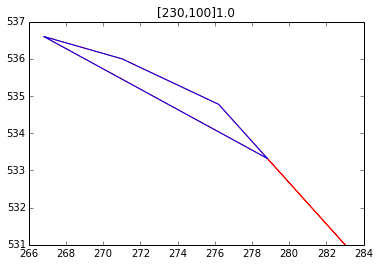

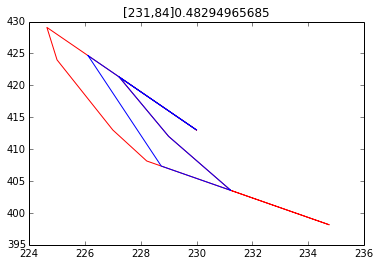

In [140]:
import copy
objid=10
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
###################################
tqdm_on=True
save_tiles=False
###################################
tiles=[]
if tqdm_on: 
    BB_lst = tqdm(range(len(BB)))
else:
    BB_lst=range(len(BB))
all_tiles=[]
for i in BB_lst:
    print "------------------------------Adding BB"+str(i)+"------------------------------"
    bi = BB[i]
    # base case, when i=0, only 2 polygon intersecting
    if i==0:
        tiles.append(bi)
    else: 
        xj_lst = []
        tiles_tmp =copy.deepcopy(tiles)
        for tj in tiles:

            try:
                xj=tj.intersection(bi)
                if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
                    diff_region = tj.difference(xj)
                    if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                        tiles_tmp.remove(tj)
                        #print "Adding intersection starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,xj)
                        #print "Adding diff_region starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,diff_region)
                        if xj.intersection(diff_region).area>1e-8:
                            print "break #1"
                            break
                        if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                            print "break#2"
                            print xj.union(diff_region).area
                            print tj.area
                            print xj.union(diff_region).area==tj.area
                            break
                        xj_lst.append(xj)
                    else:
                        xj_lst.append(tj)
            except(shapely.errors.TopologicalError):
                print "xj list last item ignored"
                xj_lst=xj_lst[:-1]
                pass

        duplicated,uniquify_tiles = compute_unique_tileset(tiles)
        
        if duplicated:
            print "before leftover BAD: BB,continue",i
            #tiles = uniquify_tiles
            break 
        else:
            print "----------- All tiles before leftover calculation is non-overlapping ---------------"
                  

        print "Bi-(Bi intersect Uorig_tiles)"
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles))) # causes 2 duplicate tiles
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles_tmp)))
        leftovers = bi
        throw_out_later = []
        for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
            try:
                leftovers = leftovers.difference(t) 
            except(shapely.geos.TopologicalError):
                print "First toplological error, tile",tidx
                try:
                    leftovers = leftovers.difference(t.buffer(-1e-10))
                except(shapely.geos.TopologicalError):
                    print "Throw out later : Topological error #67, tile",tidx
                    throw_out_later.append(t)              
#             if i==4:
#                 uniquify_tiles = compute_unique_tileset(tiles)
#                 boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
#                 if not boolean_uniquify_tiles:
#                     print "doing leftover BAD: BB,continue, tile",tidx
#                     tiles = uniquify_tiles
#                     break 

        for tidx,tile in  enumerate(throw_out_later):
            print "diffing tile#",tidx
            try:
                leftovers = leftovers.difference(tile) 
            except(shapely.geos.TopologicalError):
                try:
                    leftovers = leftovers.difference(tile.buffer(1e-10))
                except(shapely.geos.TopologicalError):
                    leftovers = leftovers.buffer(1e-50).difference(tile)
#                 try:
                    
#                 except(shapely.geos.TopologicalError):
#                     leftovers = leftovers.buffer(1e-10).difference(tile.buffer(1e-10))
        tiles =copy.deepcopy(tiles_tmp)

        print "Adding leftovers starting: ",len(tiles)
        add_object_to_tiles(tiles,leftovers)
        print "Finished leftovers starting: ",len(tiles)
    all_tiles.append(tiles)
    #uniqufy check !!
    duplicated,uniquify_tiles = compute_unique_tileset(tiles)
    #boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
    if duplicated:
        print "BAD: BB, continuing but remove duplicates",i
        tiles = uniquify_tiles
        #return tiles
#         break
#     if i ==6:
#         break 

# if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

In [142]:
tiles_check_every = tiles

In [144]:
len(tiles_check_every)

519

In [145]:
compute_unique_tileset(tiles_check_every)

 76%|███████▌  | 392/519 [00:18<00:06, 21.10it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (531.571 248.095, 528.452 243.935) and LINESTRING (528.8 244.4, 528.8 244.4) at 528.80000000000018 244.40000000000015
                                                 

Topological Error 395 297


(False,
  <shapely.geometry.polygon.Polygon at 0x113115810>])

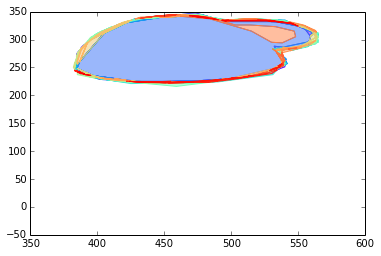

In [143]:
visualizeTilesSeparate(tiles_check_every)

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  4
Finished leftovers starting:  7
------------------------------Adding BB2------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------


Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  29
Finished leftovers starting:  39
------------------------------Adding BB3------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 67
Finished leftovers starting:  70
------------------------------Adding BB4------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.052 248.345, 536.739 253.071) and LINESTRING (535.052 248.345, 538.045 256.727) at 535.24490154631417 248.8857243296795



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (519.692 334.692, 530.182 334.273) and LINESTRING (530.182 334.273, 525.676 334.453) at 529.39189382046516 334.3043242471814
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533 246, 527.207 242.276) and LINESTRING (538.045 256.727, 527.207 242.276) at 527.2068965517243 242.27586206896567


 38
First toplological error, tile 45
First toplological error, tile 55
Adding leftovers starting: 

 105
Finished leftovers starting:  113
------------------------------Adding BB5------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (386.815 260.579, 386.815 260.579) and LINESTRING (385.538 257.038, 386.815 260.579) at 386.81523500810374 260.578606158833



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533.822 280.257, 532.97 283.876) and LINESTRING (532.97 283.876, 538.352 286.268) at 532.97041420118342 283.87573964497039


 114
First toplological error, tile 153
Adding leftovers starting: 

 177
Finished leftovers starting:  177
------------------------------Adding BB6------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533 282, 535.844 274.281) and LINESTRING (535.84 274.288, 535.844 274.281) at 535.84374999999989 274.28125000000028



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (558.061 296.515, 563.548 304.355) and LINESTRING (562 309, 563.548 304.355) at 563.54838709677415 304.35483870967744


 198
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.776 276.204, 534.14 278.907) and LINESTRING (534.776 276.204, 534.14 278.907) at 534.52119820558312 277.28490762627132


 209
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.14 278.907, 534.14 278.907) and LINESTRING (534.14 278.907, 534.14 278.907) at 534.13953488372101 278.90697674418578


 225
First toplological error, tile 226
Adding leftovers starting: 

 89%|████████▉ | 210/236 [00:05<00:00, 37.96it/s]

 230
Finished leftovers starting:  236
------------------------------Adding BB7------------------------------
Duplicate tiles:  230 100 1.0
Duplicate tiles: 

 231 84 0.48294965685
before leftover BAD: BB,continue 7


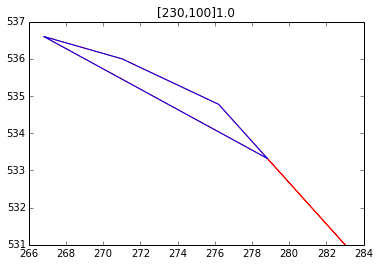

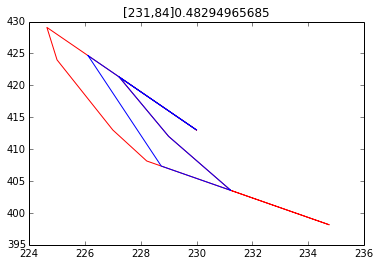

In [146]:
import copy
objid=10
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
###################################
tqdm_on=True
save_tiles=False
###################################
tiles=[]
if tqdm_on: 
    BB_lst = tqdm(range(len(BB)))
else:
    BB_lst=range(len(BB))

for i in BB_lst:
    print "------------------------------Adding BB"+str(i)+"------------------------------"
    bi = BB[i]
    # base case, when i=0, only 2 polygon intersecting
    if i==0:
        tiles.append(bi)
    else: 
        xj_lst = []
        tiles_tmp =copy.deepcopy(tiles)
        for tj in tiles:

            try:
                xj=tj.intersection(bi)
                if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
                    diff_region = tj.difference(xj)
                    if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                        tiles_tmp.remove(tj)
                        #print "Adding intersection starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,xj)
                        #print "Adding diff_region starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,diff_region)
                        if xj.intersection(diff_region).area>1e-8:
                            print "break #1"
                            break
                        if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                            print "break#2"
                            print xj.union(diff_region).area
                            print tj.area
                            print xj.union(diff_region).area==tj.area
                            break
                        xj_lst.append(xj)
                    else:
                        xj_lst.append(tj)
            except(shapely.errors.TopologicalError):
                print "xj list last item ignored"
                xj_lst=xj_lst[:-1]
                pass

        duplicated,uniquify_tiles = compute_unique_tileset(tiles)
        
        if duplicated:
            print "before leftover BAD: BB,continue",i
            #tiles = uniquify_tiles
            break 
        else:
            print "----------- All tiles before leftover calculation is non-overlapping ---------------"
                  

        print "Bi-(Bi intersect Uorig_tiles)"
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles))) # causes 2 duplicate tiles
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles_tmp)))
        leftovers = bi
        throw_out_later = []
        for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
            try:
                leftovers = leftovers.difference(t) 
            except(shapely.geos.TopologicalError):
                print "First toplological error, tile",tidx
                try:
                    leftovers = leftovers.difference(t.buffer(-1e-10))
                except(shapely.geos.TopologicalError):
                    print "Throw out later : Topological error #67, tile",tidx
                    throw_out_later.append(t)              
#             if i==4:
#                 uniquify_tiles = compute_unique_tileset(tiles)
#                 boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
#                 if not boolean_uniquify_tiles:
#                     print "doing leftover BAD: BB,continue, tile",tidx
#                     tiles = uniquify_tiles
#                     break 

        for tidx,tile in  enumerate(throw_out_later):
            print "diffing tile#",tidx
            try:
                leftovers = leftovers.difference(tile) 
            except(shapely.geos.TopologicalError):
                try:
                    leftovers = leftovers.difference(tile.buffer(1e-10))
                except(shapely.geos.TopologicalError):
                    leftovers = leftovers.buffer(1e-50).difference(tile)
#                 try:
                    
#                 except(shapely.geos.TopologicalError):
#                     leftovers = leftovers.buffer(1e-10).difference(tile.buffer(1e-10))
        tiles =copy.deepcopy(tiles_tmp)

        print "Adding leftovers starting: ",len(tiles)
        add_object_to_tiles(tiles,leftovers)
        print "Finished leftovers starting: ",len(tiles)
if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))
#     all_tiles.append(tiles)
    #uniqufy check !!
#     duplicated,uniquify_tiles = compute_unique_tileset(tiles)
#     #boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
#     if duplicated:
#         print "BAD: BB, continuing but remove duplicates",i
#         tiles = uniquify_tiles
        #return tiles
#         break
#     if i ==6:
#         break 
# if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

In [148]:
duplicated,verified_tiles=compute_unique_tileset(tiles_check_every)

 75%|███████▌  | 390/519 [00:17<00:05, 21.69it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (531.571 248.095, 528.452 243.935) and LINESTRING (528.8 244.4, 528.8 244.4) at 528.80000000000018 244.40000000000015
                                                 

Topological Error 395 297


 95%|█████████▌| 225/236 [00:06<00:00, 35.23it/s]

Duplicate tiles:  230 100 1.0
Duplicate tiles: 

 231 84 0.48294965685


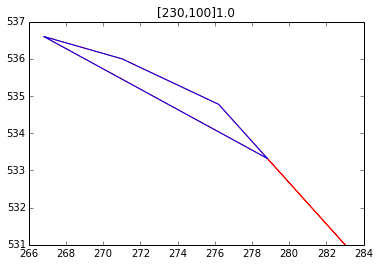

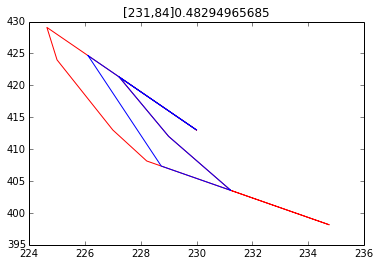

In [149]:
duplicated,verified_tiles=compute_unique_tileset(tiles)

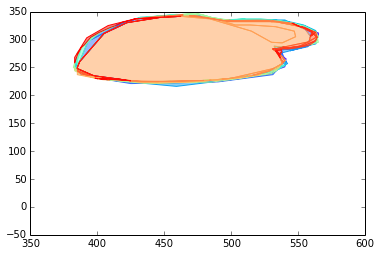

In [147]:
visualizeTilesSeparate(tiles)

 92%|█████████▏| 216/236 [00:05<00:00, 39.56it/s]

Duplicate tiles:  230 100 1.0
Duplicate tiles: 

 231 84 0.48294965685


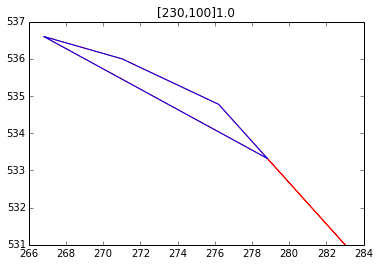

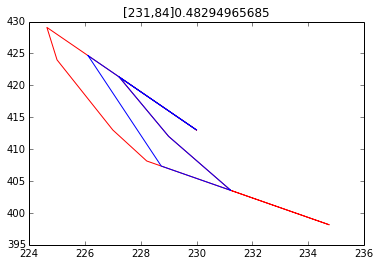

In [137]:
duplicated,verified_tiles = compute_unique_tileset(tiles)

In [139]:
duplicated,verified_tiles2 =compute_unique_tileset(verified_tiles)

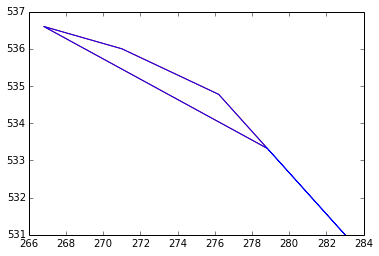

In [89]:
plot_coords(tiles[101])
plot_coords(tiles[36],color="blue")

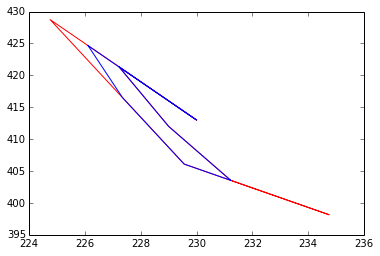

In [86]:
plot_coords(tiles[381])
plot_coords(tiles[412],color='blue')

In [80]:
compute_verfied_tiles_duplication_rate(tiles)

 74%|███████▎  | 392/532 [00:18<00:06, 21.09it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (531.571 248.095, 528.452 243.935) and LINESTRING (528.8 244.4, 528.8 244.4) at 528.80000000000018 244.40000000000015


Duplicate tiles:  101 36 1.0
Error 402 301
Duplicate tiles: 

 95%|█████████▍| 504/532 [00:31<00:01, 16.01it/s]

 412 381 0.822388219911
Duplicate tiles: 

 530 342 0.980785296569
Duplication rate:  0.00563909774436


In [78]:
leftovers

1247.509176468278

In [69]:
leftovers.area

1254.5398685503408

In [75]:
leftovers.buffer(1e-50).area

1251.0533683874687

In [73]:
leftovers.buffer(1e-50).difference(tile).area

1247.509176468278

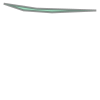

In [56]:
tiles[198]

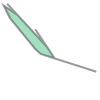

In [52]:
tiles[533]

In [50]:
tiles[536].difference(tiles[536].buffer(-1e-10)).area

9.550076285336218e-10

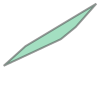

In [48]:
tiles[536].buffer(-1e-10)

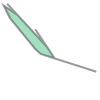

In [46]:
tiles[533]

In [ ]:
tiles[84]= tiles[84].difference(tiles[232])

In [22]:
tile = tiles[1]
tile.is_closed

False

In [25]:
tile.is_valid

True

In [26]:
tiles[84].is_valid

True

In [29]:
tile = tiles[232]

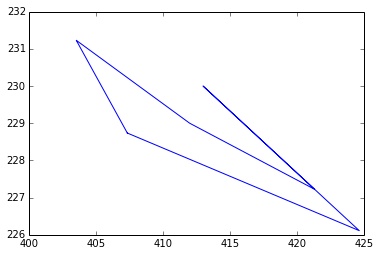

In [36]:
plt.plot(tile.boundary.xy[0],tile.boundary.xy[1])

In [42]:
from shapely.validation import explain_validity
tile = tiles[232].buffer(-1e-10)
explain_validity(tile)

'Valid Geometry'

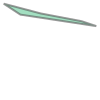

In [43]:
tile

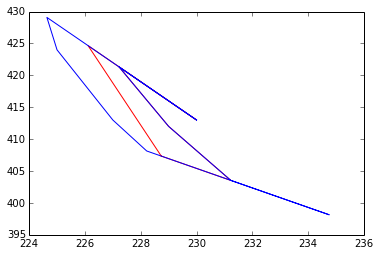

In [16]:
plot_coords(tiles[232])
plot_coords(tiles[84],color="blue")

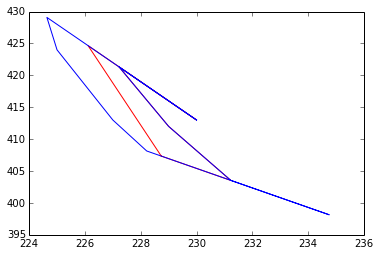

In [70]:
plot_coords(tiles[232])
plot_coords(tiles[84],color="blue")

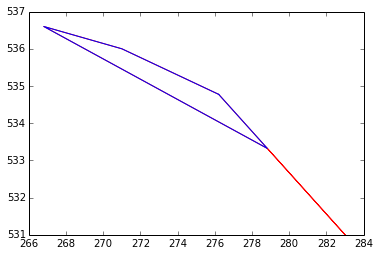

In [69]:
plot_coords(tiles[100])
plot_coords(tiles[229],color="blue")

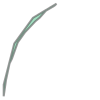

In [62]:
tiles[229]

In [38]:
throw_out_later[0].area

2.993761038547241

--------------------------------------------------------------------------------------------------------------

In [168]:
def join_tiles(solutionList,tiles): 
    '''
    Given a solutionList of tile indicies, join the tiles together into a Polygon/MultiPolygon object.
    '''
    try:
        return cascaded_union([tiles[tidx] for tidx in solutionList]),[]
    except:
        #slow version, run through and exclude problematic solutionset item
        Utile=tiles[0]
        problematic_tiles =[]
        for soln in solutionList:
            try:
                Utile=Utile.union(tiles[soln])
            except(shapely.geos.TopologicalError):
                problematic_tiles.append(tiles[soln])
        problematic_tiles.append(Utile)
        return Utile,problematic_tiles
def PR_compare(objid,tiles,sampleNworkers=40):    
    #os.chdir("..")
    # worker_lst,tiles,indicatorMat= createObjIndicatorMatrix(objid,PRINT=True,sampleNworkers=sampleNworkers,tqdm_on=False,tile_only=False)
    #worker_lst = pkl.load(open("{0}/worker{1}.pkl".format(DATA_DIR,objid),'r'))
    #tiles = pkl.load(open("{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
    #objIndicatorMat = pkl.load(open("{0}/indMat{1}.pkl".format(DATA_DIR,objid),'r'))
    worker_lst,tiles,indicatorMat= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
#     os.chdir(DATA_DIR)
    
    worker_precision_lst,worker_recall_lst = compute_worker_lst_PR_obj(objid,worker_lst)
    best_worker =  np.argmax(worker_recall_lst)
    print "Best worker's PR against BBG: ", max(worker_precision_lst),max(worker_recall_lst)

    approved_tiles = np.where(indicatorMat[best_worker]==1)[0]
    for tidx in approved_tiles:
        plot_coords(tiles[tidx],color="lime")

    bb_objects = bb_info[bb_info["object_id"]==objid]
    bb_objects =  bb_objects[bb_objects.worker_id!=3]
    best_worker_id = worker_lst[best_worker]
    print best_worker_id
    worker_bb_info = bb_objects[bb_objects["worker_id"]==best_worker_id]
    worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]])))#.buffer(0)

    plot_coords(worker_BB_polygon,linestyle='--',color='#0000ff')
    
    joined_bb,problematic_tiles = join_tiles(approved_tiles,tiles)
    if problematic_tiles==[]:
        intersect_area = worker_BB_polygon.intersection(joined_bb).area
    else:
        intersect_area =0# worker_BB_polygon.intersection(joined_bb).area
#         for problematic_tile in problematic_tiles:
        for tidx in approved_tiles:
            intersect_area +=worker_BB_polygon.intersection(tiles[tidx]).area
    precision = intersect_area/joined_bb.area
    recall = intersect_area/worker_BB_polygon.area
    
    if precision>1:
        precision=1
    if recall>1:
        recall=1
    print "Joined BB PR:", precision,recall    
    return precision,recall

In [20]:
unique_tiles = compute_unique_tileset(tiles)
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=unique_tiles,sampleNworkers=10)

Best worker's PR against BBG:  0.973312843473 0.977701312091
192

ERROR:shapely.geos:TopologyException: side location conflict at 299.65753424657532 286.41095890410958
ERROR:shapely.geos:TopologyException: EdgeRing::computePoints: found null Directed Edge
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.538 437.692, 377.231 432.154) and LINESTRING (377.231 432.154, 385.538 437.692) at 383.46153846153845 436.30769230769226
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (306.371 309.486, 306.371 309.486) and LINESTRING (306.371 309.486, 306.371 309.486) at 306.37142857142868 309.48571428571483
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (306.777 296.9, 339.354 344.487) and LINESTRING (306.777 296.9, 339.354 344.488) at 339.35344297335422 344.48689218656648
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (305.787 295.326, 306.782 296.773) and LINESTRING (306.777 296.9, 306.869 294.058) at 306.78


Joined BB PR: 1 0.950162450091


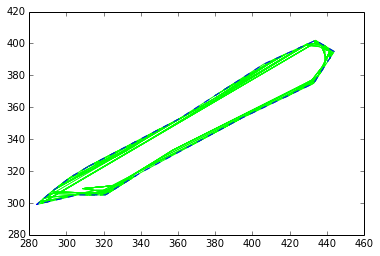

In [23]:
p,r=PR_compare(objid,unique_tiles,sampleNworkers=5)

In [111]:
# leftovers = bi
# for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
#     leftovers = leftovers.difference(t)   
#     print leftovers

Intersect before: True
2864.80421431
Intersect after: True
1.62136593675e-13
44.2252198076
2839.51615882


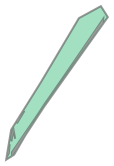

In [189]:
# leftovers = bi
# i=0
print "Intersect before:" , leftovers.intersects(tiles_tmp[i])
print leftovers.area
leftovers = leftovers.difference(tiles_tmp[i])   
print "Intersect after:" ,  leftovers.intersects(tiles_tmp[i])
print leftovers.intersection(tiles_tmp[i]).area
print tiles_tmp[i].area
print leftovers.area
i+=1


leftovers


In [ ]:
# plt.figure()
# if  type(leftovers)==shapely.geometry.MultiPolygon:
#     visualizeTilesSeparate(leftovers)
# else:
#     plot_coords(leftovers)
# plot_coords(t,color="#32cd32")

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 10
Finished leftovers starting:  19
------------------------------Adding BB2------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 41
Finished leftovers starting:  41
------------------------------Adding BB3------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 61
Finished leftovers starting:  68
------------------------------Adding BB4------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 94%|█████████▍| 112/119 [00:26<00:01,  4.16it/s]

 115
Finished leftovers starting:  119
------------------------------Adding BB5------------------------------
Duplicate tiles: 

 116 18 1.0
before leftover BAD: BB,continue

 94%|█████████▍| 112/119 [00:22<00:01,  4.89it/s]

 5
Duplicate tiles: 

 116 18 1.0
Best worker's PR against BBG:  0.990837224185 0.950324076004
238
Joined BB PR: 0.966698593059 0.943687731136


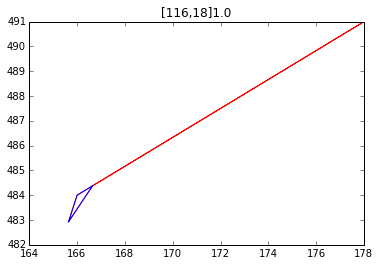

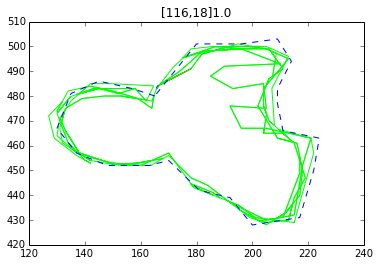

In [169]:
import copy
objid=5
sampleNworkers=-1
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
    
tiles = BB2TileExact(objid,BB)
unique_tiles = compute_unique_tileset(tiles)
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
p,r=PR_compare(objid,tiles,sampleNworkers=-1)

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  3
Finished leftovers starting:  6
------------------------------Adding BB2------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  33
Finished leftovers starting:  38
------------------------------Adding BB3------------------------------
break #1


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (67.1029 54.6912, 66.9232 54.4156) and LINESTRING (66.9092 54.3941, 67.1029 54.6912) at 66.965218231092663 54.480001287675414



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (120.56 111.48, 116 113) and LINESTRING (120.56 111.48, 120 112) at 120.55999999999997 111.48000000000002


 42
First toplological error, tile 61
Adding leftovers starting:  68
Finished leftovers starting:  68
------------------------------Adding BB4------------------------------
break#2

 94%|█████████▍| 64/68 [00:04<00:00, 13.07it/s]


5311.34016035
5336.52287271
False
Duplicate tiles: 

 67 62 0.89802028383
before leftover BAD: BB,continue

 96%|█████████▌| 65/68 [00:05<00:00, 12.84it/s]

 4
Duplicate tiles: 

 67 62 0.89802028383
Best worker's PR against BBG:  0.852042398034 0.994602705259
133
Joined BB PR: 1.0 0.99995870219


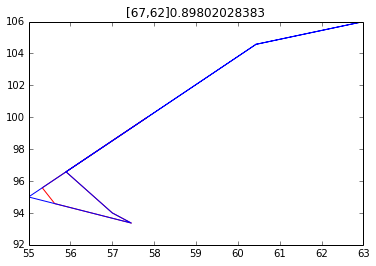

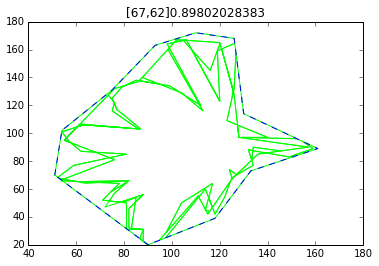

In [172]:
import copy
objid=30
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
    
tiles = BB2TileExact(objid,BB)
unique_tiles = compute_unique_tileset(tiles)
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
p,r=PR_compare(objid,tiles,sampleNworkers=-1)

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  9
Finished leftovers starting:  16
------------------------------Adding BB2------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 34
Finished leftovers starting:  43
------------------------------Adding BB3------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 82
Finished leftovers starting:  82
------------------------------Adding BB4------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604 265, 602.645 262.459) and LINESTRING (603.958 265.625, 602.745 262.647) at 602.74509803921558 262.64705882352939



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604.471 266.882, 604.471 266.882) and LINESTRING (604.471 266.882, 604.471 266.882) at 604.47058823529403 266.88235294117612


 73
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (593.478 248.696, 595.752 252.003) and LINESTRING (593 248, 599.839 257.948) at 594.41363519898243 250.0561966530654


 100
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 601.62162162162122 260.54054054053978


 102
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (430.452 227.279, 429.227 230.136) and LINESTRING (429.227 230.136, 431 224) at 429.22727272727298 230.136363636363


 104
First toplological error, tile 109
Adding leftovers starting: 

 84%|████████▍ | 112/133 [00:24<00:04,  4.51it/s]

 122
Finished leftovers starting:  133
------------------------------Adding BB5------------------------------
Duplicate tiles: 

 125 31 0.244919542748
before leftover BAD: BB,continue

 84%|████████▍ | 112/133 [00:28<00:05,  3.93it/s]

 5
Duplicate tiles: 

 125 31 0.244919542748
Best worker's PR against BBG:  0.97926068494 0.997923402884
123

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (602.745 262.647, 604 265) and LINESTRING (603.958 265.625, 602.273 261.488) at 602.74509803921569 262.64705882352945
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604.952 268.064, 604.413 266.741) and LINESTRING (604.471 266.882, 604.29 266.161) at 604.47058823529414 266.88235294117624
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (593.478 248.696, 595.203 251.205) and LINESTRING (593.478 248.696, 595.691 251.914) at 594.52668403984967 250.2206313306904
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (571.816 214.989, 571.594 214.687) and LINESTRING (571.594 214.687, 572.302 215.651) at 571.80861482089222 214.97971615641339
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (558.569 200.843, 558.569 200.843) and LINESTRING (558.569 200.843, 558.569 


Joined BB PR: 0.988638693592 0.991567585447


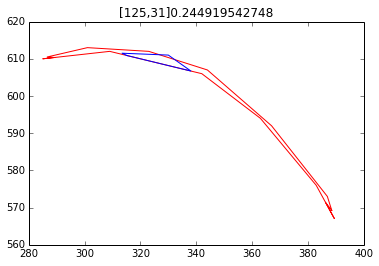

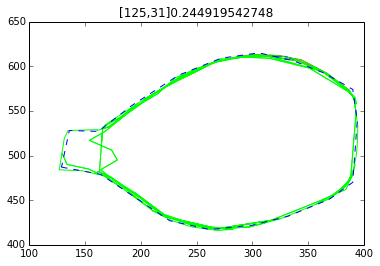

In [173]:
import copy
objid=33
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
    
tiles = BB2TileExact(objid,BB)
unique_tiles = compute_unique_tileset(tiles)
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
p,r=PR_compare(objid,tiles,sampleNworkers=-1)

In [194]:
def BB2TileExact(objid,BB,tqdm_on=False,save_tiles=True,DEBUG=False):
    '''
    Given a list of worker polygons BB (potentially sampled) and the objectID 
    return a list of non-overlapping tiles (shapely Polygon objects)
    # BB is a list of polygons based on worker BBs 
    '''
    tiles=[]
    if tqdm_on: 
        BB_lst = tqdm(range(len(BB)))
    else:
        BB_lst=range(len(BB))

    for i in BB_lst:
        if DEBUG: print "------------------------------Adding BB"+str(i)+"------------------------------"
        bi = BB[i]
        # base case, when i=0, only 2 polygon intersecting
        if i==0:
            tiles.append(bi)
        else: 
            xj_lst = []
            tiles_tmp =copy.deepcopy(tiles)
            for tj in tiles:
                try:
                    xj=tj.intersection(bi)
                    if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
                        diff_region = tj.difference(xj)
                        if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                            tiles_tmp.remove(tj)
                            #print "Adding intersection starting: ",len(tiles)
                            add_object_to_tiles(tiles_tmp,xj)
                            #print "Adding diff_region starting: ",len(tiles)
                            add_object_to_tiles(tiles_tmp,diff_region)
                            if DEBUG:
                                if xj.intersection(diff_region).area>1e-8:
                                    print "break #1"
                                    break
                                if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                                    print "break#2"
                                    print xj.union(diff_region).area
                                    print tj.area
                                    print xj.union(diff_region).area==tj.area
                                    break
                            xj_lst.append(xj)
                        else:
                            xj_lst.append(tj)
                except(shapely.errors.TopologicalError):
                    if DEBUG: print "xj list last item ignored"
                    xj_lst=xj_lst[:-1]
                    pass
            if DEBUG: 
                duplicated,uniquify_tiles = compute_unique_tileset(tiles)

                if duplicated:
                    print "before leftover BAD: BB,continue",i
                    #tiles = uniquify_tiles
                    break 
                else:
                    print "----------- All tiles before leftover calculation is non-overlapping ---------------"

                print "Bi-(Bi intersect Uorig_tiles)"
            leftovers = bi
            throw_out_later = []
            for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
                try:
                    leftovers = leftovers.difference(t) 
                except(shapely.geos.TopologicalError):
                    if DEBUG: print "First toplological error, tile",tidx
                    try:
                        leftovers = leftovers.difference(t.buffer(-1e-10))
                    except(shapely.geos.TopologicalError):
                        if DEBUG: print "Throw out later : Topological error #67, tile",tidx
                        throw_out_later.append(t)              

            for tidx,tile in  enumerate(throw_out_later):
                if DEBUG: print "diffing tile#",tidx
                try:
                    leftovers = leftovers.difference(tile) 
                except(shapely.geos.TopologicalError):
                    try:
                        leftovers = leftovers.difference(tile.buffer(1e-10))
                    except(shapely.geos.TopologicalError):
                        leftovers = leftovers.buffer(1e-10).difference(tile)
            tiles =copy.deepcopy(tiles_tmp)

            if DEBUG: print "Adding leftovers starting: ",len(tiles)
            add_object_to_tiles(tiles,leftovers)
            if DEBUG: print "Finished leftovers starting: ",len(tiles)
    if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))
    return tiles

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (263 113, 293.386 111.04) and LINESTRING (233.001 111.97, 292.796 111.078) at 292.79611650485435 111.07766990291262
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (246.814 111.745, 294.912 111.016) and LINESTRING (293.386 111.04, 246.814 111.745) at 249.62909453184693 111.70258947679021
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (230 113, 246.814 111.745) and LINESTRING (246.814 111.745, 233.826 111.942) at 246.8136882129277 111.74524714828898
 34%|███▍      | 45/133 [00:02<00:04, 20.83it/s]

Topological Error 28 12
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (246.814 111.745, 294.912 111.016) and LINESTRING (293.386 111.04, 246.814 111.745) at 249.62909453184693 111.70258947679021
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (246.814 111.745, 294.912 111.016) and LINESTRING (293.386 111.04, 246.814 111.745) at 249.62909453184693 111.70258947679021


 53 38 0.645806607395
Best worker's PR against BBG:  1.0 0.99929973859
174

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (294.592 76.6901, 295.636 90.2727) and LINESTRING (295.636 90.2727, 295.544 85) at 295.63636363636368 90.272727272726954
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (233.826 111.942, 233.826 111.942) and LINESTRING (233.826 111.942, 233.826 111.942) at 233.82608695652061 111.94202898550726
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (233.001 111.955, 233.001 111.966) and LINESTRING (233.001 111.968, 233.001 111.955) at 233.00067567955151 111.96283762466602
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (292.796 111.078, 246.5 111.769) and LINESTRING (246.5 111.769, 292.796 111.078) at 248.45737257281556 111.73944220040573
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (280.664 55.3981, 260.5 56) and LINESTRING (289.411 55.137, 264.779 55.8723


Joined BB PR: 1 0.83099619491


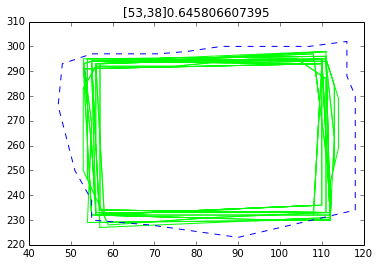

In [195]:
import copy
objid=21
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
    
tiles = BB2TileExact(objid,BB)
unique_tiles = compute_unique_tileset(tiles)
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
p,r=PR_compare(objid,tiles,sampleNworkers=-1)

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (413.667 63.2778, 410.183 63.1326) and LINESTRING (413.667 63.2778, 409.748 63.1145) at 411.92111170612702 63.205046321088624
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (426.6 52.6, 427.5 53.5) and LINESTRING (427.5 53.5, 427.368 52.8392) at 427.5 53.499999999999943
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (393.627 60.4337, 393.627 60.4337) and LINESTRING (393.627 60.4337, 387.774 60.1948) at 393.62650602409644 60.433734939759034
                                                 

Duplicate tiles:  52 16 0.472487862513
Best worker's PR against BBG:  0.942954516257 1.0
129

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (391.692 56.1538, 404.377 52.0399) and LINESTRING (409.813 50.2768, 396.704 54.5285) at 403.23980938681365 52.408710469141518
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 410 47 at 410 47
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (390.4 56.8, 391.692 56.1538) and LINESTRING (391.692 56.1538, 390.055 56.6849) at 391.69230769230768 56.153846153846175
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (387.553 58.2589, 388.533 58.4222) and LINESTRING (387.5 58.25, 388.533 58.4222) at 387.68219573531536 58.280365955885863
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (391.692 56.1538, 390.055 56.6849) and LINESTRING (391.692 56.1538, 391.692 56.1538) at 391.69230769230768 56.153846153846153
ERROR:shapely.geos:TopologyException: found no


Joined BB PR: 1 0.320209307024


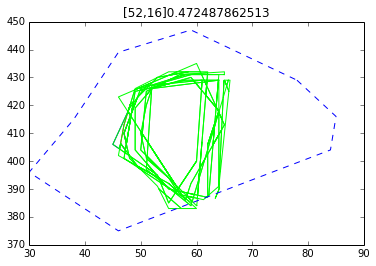

In [196]:
import copy
objid=15
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
    
tiles = BB2TileExact(objid,BB)
unique_tiles = compute_unique_tileset(tiles)
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
p,r=PR_compare(objid,tiles,sampleNworkers=-1)

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  9
Finished leftovers starting:  16
------------------------------Adding BB2------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 34
Finished leftovers starting:  43
------------------------------Adding BB3------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 82
Finished leftovers starting:  82
------------------------------Adding BB4------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604 265, 602.645 262.459) and LINESTRING (603.958 265.625, 602.745 262.647) at 602.74509803921558 262.64705882352939



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604.471 266.882, 604.471 266.882) and LINESTRING (604.471 266.882, 604.471 266.882) at 604.47058823529403 266.88235294117612


 73
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (593.478 248.696, 595.752 252.003) and LINESTRING (593 248, 599.839 257.948) at 594.41363519898243 250.0561966530654


 100
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 601.62162162162122 260.54054054053978


 102
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (430.452 227.279, 429.227 230.136) and LINESTRING (429.227 230.136, 431 224) at 429.22727272727298 230.136363636363


 104
First toplological error, tile 109
Adding leftovers starting: 

 90%|█████████ | 120/133 [00:27<00:03,  4.31it/s]

 122
Finished leftovers starting:  133
------------------------------Adding BB5------------------------------
Duplicate tiles: 

 125 31 0.244919542748
before leftover BAD: BB,continue

 90%|█████████ | 120/133 [00:27<00:03,  4.29it/s]

 5
Duplicate tiles: 

 125 31 0.244919542748
Best worker's PR against BBG:  0.97926068494 0.997923402884
123

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (602.745 262.647, 604 265) and LINESTRING (603.958 265.625, 602.273 261.488) at 602.74509803921569 262.64705882352945
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604.952 268.064, 604.413 266.741) and LINESTRING (604.471 266.882, 604.29 266.161) at 604.47058823529414 266.88235294117624
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (593.478 248.696, 595.203 251.205) and LINESTRING (593.478 248.696, 595.691 251.914) at 594.52668403984967 250.2206313306904
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (571.816 214.989, 571.594 214.687) and LINESTRING (571.594 214.687, 572.302 215.651) at 571.80861482089222 214.97971615641339
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (558.569 200.843, 558.569 200.843) and LINESTRING (558.569 200.843, 558.569 


Joined BB PR: 0.988638693592 0.991567585447


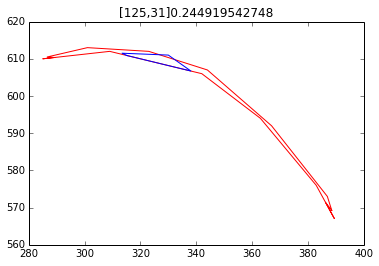

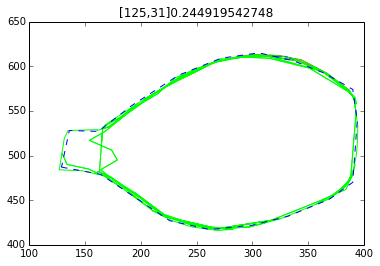

In [179]:
import copy
objid=33
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
    
tiles = BB2TileExact(objid,BB)
unique_tiles = compute_unique_tileset(tiles)
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
p,r=PR_compare(objid,tiles,sampleNworkers=-1)

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  9
Finished leftovers starting:  16
------------------------------Adding BB2------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 34
Finished leftovers starting:  43
------------------------------Adding BB3------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 82
Finished leftovers starting:  82
------------------------------Adding BB4------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604 265, 602.645 262.459) and LINESTRING (603.958 265.625, 602.745 262.647) at 602.74509803921558 262.64705882352939



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604.471 266.882, 604.471 266.882) and LINESTRING (604.471 266.882, 604.471 266.882) at 604.47058823529403 266.88235294117612


 73
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (593.478 248.696, 595.752 252.003) and LINESTRING (593 248, 599.839 257.948) at 594.41363519898243 250.0561966530654
ERROR:shapely.geos:TopologyException: side location conflict at 601.62162162162122 260.54054054053978


 100
First toplological error, tile 102
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (430.452 227.279, 429.227 230.136) and LINESTRING (429.227 230.136, 431 224) at 429.22727272727298 230.136363636363


 104
First toplological error, tile 109
Adding leftovers starting: 

 84%|████████▍ | 112/133 [00:21<00:04,  5.13it/s]

 122
Finished leftovers starting:  133
------------------------------Adding BB5------------------------------
Duplicate tiles: 

 125 31 0.244919542748
before leftover BAD: BB,continue

 84%|████████▍ | 112/133 [00:24<00:04,  4.63it/s]

 5
Duplicate tiles: 

 125 31 0.244919542748
Best worker's PR against BBG:  0.97926068494 0.997923402884
123

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (602.745 262.647, 604 265) and LINESTRING (603.958 265.625, 602.273 261.488) at 602.74509803921569 262.64705882352945
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604.952 268.064, 604.413 266.741) and LINESTRING (604.471 266.882, 604.29 266.161) at 604.47058823529414 266.88235294117624
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (593.478 248.696, 595.203 251.205) and LINESTRING (593.478 248.696, 595.691 251.914) at 594.52668403984967 250.2206313306904
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (571.816 214.989, 571.594 214.687) and LINESTRING (571.594 214.687, 572.302 215.651) at 571.80861482089222 214.97971615641339
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (558.569 200.843, 558.569 200.843) and LINESTRING (558.569 200.843, 558.569 


Joined BB PR: 0.988638693592 0.991567585447


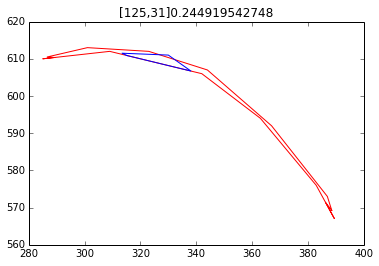

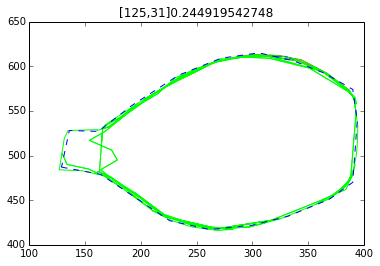

In [186]:
import copy
objid=33
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
    
tiles = BB2TileExact(objid,BB)
unique_tiles = compute_unique_tileset(tiles)
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
p,r=PR_compare(objid,tiles,sampleNworkers=-1)

In [192]:
def BB2TileExact(objid,BB,tqdm_on=False,save_tiles=True):
    '''
    Given a list of worker polygons BB (potentially sampled) and the objectID 
    return a list of non-overlapping tiles (shapely Polygon objects)
    # BB is a list of polygons based on worker BBs 
    '''
    tiles=[]
    if tqdm_on: 
        BB_lst = tqdm(range(len(BB)))
    else:
        BB_lst=range(len(BB))

    for i in BB_lst:
        print "------------------------------Adding BB"+str(i)+"------------------------------"
        bi = BB[i]
        # base case, when i=0, only 2 polygon intersecting
        if i==0:
            tiles.append(bi)
        else: 
            xj_lst = []
            tiles_tmp =copy.deepcopy(tiles)
            for tj in tiles:

                try:
                    xj=tj.intersection(bi)
                    if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
                        diff_region = tj.difference(xj)
                        if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                            tiles_tmp.remove(tj)
                            #print "Adding intersection starting: ",len(tiles)
                            add_object_to_tiles(tiles_tmp,xj)
                            #print "Adding diff_region starting: ",len(tiles)
                            add_object_to_tiles(tiles_tmp,diff_region)
                            if xj.intersection(diff_region).area>1e-8:
                                print "break #1"
                                break
                            if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                                print "break#2"
                                print xj.union(diff_region).area
                                print tj.area
                                print xj.union(diff_region).area==tj.area
                                break
                            xj_lst.append(xj)
                        else:
                            xj_lst.append(tj)
                except(shapely.errors.TopologicalError):
                    print "xj list last item ignored"
                    xj_lst=xj_lst[:-1]
                    pass

#             duplicated,uniquify_tiles = compute_unique_tileset(tiles)

#             if duplicated:
#                 print "before leftover BAD: BB,continue",i
#                 #tiles = uniquify_tiles
#                 break 
#             else:
#                 print "----------- All tiles before leftover calculation is non-overlapping ---------------"


            print "Bi-(Bi intersect Uorig_tiles)"
            #leftovers = bi.difference(bi.intersection(cascaded_union(tiles))) # causes 2 duplicate tiles
            #leftovers = bi.difference(bi.intersection(cascaded_union(tiles_tmp)))
            leftovers = bi
            throw_out_later = []
            for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
                try:
                    leftovers = leftovers.difference(t) 
                except(shapely.geos.TopologicalError):
                    print "First toplological error, tile",tidx
                    try:
                        leftovers = leftovers.difference(t.buffer(-1e-10))
                    except(shapely.geos.TopologicalError):
                        print "Throw out later : Topological error #67, tile",tidx
                        throw_out_later.append(t)              
    #             if i==4:
    #                 uniquify_tiles = compute_unique_tileset(tiles)
    #                 boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
    #                 if not boolean_uniquify_tiles:
    #                     print "doing leftover BAD: BB,continue, tile",tidx
    #                     tiles = uniquify_tiles
    #                     break 

            for tidx,tile in  enumerate(throw_out_later):
                print "diffing tile#",tidx
                try:
                    leftovers = leftovers.difference(tile) 
                except(shapely.geos.TopologicalError):
                    try:
                        leftovers = leftovers.difference(tile.buffer(1e-10))
                    except(shapely.geos.TopologicalError):
                        leftovers = leftovers.buffer(1e-10).difference(tile)
    #                 try:

    #                 except(shapely.geos.TopologicalError):
    #                     leftovers = leftovers.buffer(1e-10).difference(tile.buffer(1e-10))
            tiles =copy.deepcopy(tiles_tmp)

            print "Adding leftovers starting: ",len(tiles)
            add_object_to_tiles(tiles,leftovers)
            print "Finished leftovers starting: ",len(tiles)
    if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))
    return tiles

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  9
Finished leftovers starting:  16
------------------------------Adding BB2------------------------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  34
Finished leftovers starting:  43
------------------------------Adding BB3------------------------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  82
Finished leftovers starting:  82
------------------------------Adding BB4------------------------------
Bi-(Bi intersect Uorig_tiles)

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604 265, 602.645 262.459) and LINESTRING (603.958 265.625, 602.745 262.647) at 602.74509803921558 262.64705882352939



First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604.471 266.882, 604.471 266.882) and LINESTRING (604.471 266.882, 604.471 266.882) at 604.47058823529403 266.88235294117612


 73
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (593.478 248.696, 595.752 252.003) and LINESTRING (593 248, 599.839 257.948) at 594.41363519898243 250.0561966530654


 100
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 601.62162162162122 260.54054054053978


 102
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (430.452 227.279, 429.227 230.136) and LINESTRING (429.227 230.136, 431 224) at 429.22727272727298 230.136363636363


 104
First toplological error, tile 109
Adding leftovers starting:  122
Finished leftovers starting:  133
------------------------------Adding BB5------------------------------
Bi-(Bi intersect Uorig_tiles)

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (576.713 221.856, 578.116 223.103) and LINESTRING (576.71 221.853, 577.067 222.171) at 577.05965107061547 222.16413428499155



First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (429.227 230.136, 429.227 230.136) and LINESTRING (426.5 236.5, 429.227 230.136) at 429.22727272727275 230.13636363636363


 124
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (429.227 230.136, 430.771 226.534) and LINESTRING (430.771 226.534, 430.771 226.534) at 430.77114793202867 226.53398815859981


 183
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (419.046 263.246, 419.714 259.571) and LINESTRING (419.714 259.571, 419.714 259.571) at 419.71428571495233 259.57142856776238


 184
First toplological error, tile 185
Adding leftovers starting:  207
Finished leftovers starting:  214
------------------------------Adding BB6------------------------------
Bi-(Bi intersect Uorig_tiles)

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (418.35 267.075, 418.478 266.373) and LINESTRING (419.577 260.329, 418.35 267.075) at 418.43059064081507 266.63175147551726



First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (569 389, 584 374) and LINESTRING (584 374, 575.711 383.211) at 583.99999999999864 374.00000000000142
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (596.958 354.62, 607.714 324.143) and LINESTRING (607.714 324.143, 607.714 324.143) at 607.71428571428555 324.14285714285757
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (419.983 262.136, 419.983 262.136) and LINESTRING (419.983 262.136, 419.983 262.136) at 419.9830508474576 262.13559322033916


 81
First toplological error, tile 89
First toplological error, tile 90
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (429.826 228.739, 430.452 227.279) and LINESTRING (429.818 228.757, 431.286 225.333) at 429.87397707596142 228.6273868227567


 103
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (421.33 251.358, 421.33 251.358) and LINESTRING (421.33 251.358, 421.33 251.358) at 421.33018867924528 251.35849056603763


 115
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (418 269, 418.471 266.409) and LINESTRING (418.35 267.075, 418.291 267.994) at 418.35000000000002 267.07499999999999


 119
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (429.792 228.818, 429.832 228.725) and LINESTRING (429.85 228.683, 426.5 236.5) at 429.81467276622703 228.76576354547035


 121
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (431.286 225.333, 430.771 226.535) and LINESTRING (430.771 226.534, 431.286 225.333) at 431.01116239566386 225.97395441011753


 122
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (441 210, 436.806 216.029) and LINESTRING (436.806 216.029, 444.31 208.084) at 436.80582524271853 216.02912621359212


 155
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (549.4 392.733, 548.214 392.959) and LINESTRING (548.712 392.864, 549.4 392.733) at 548.94193642624646 392.82058353785783


 161
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (460.239 376.821, 457.385 374.615) and LINESTRING (460.239 376.821, 455 371) at 460.23880597014914 376.82089552238796


 167
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (426.502 312.281, 418.843 273.289) and LINESTRING (420 289, 419.552 276.9) at 419.55186721991703 276.90041493775948


 169
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (444.31 208.084, 439.048 213.655) and LINESTRING (441.808 210.732, 436.806 216.029) at 439.79549663356971 212.86359179974968


 175
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (420 299, 419.848 296.723) and LINESTRING (419.848 296.723, 422.396 304.527) at 419.84816753926702 296.72251308900525


 185
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (420 299, 419.848 296.723) and LINESTRING (419.848 296.723, 422.396 304.527) at 419.84816753926702 296.72251308900525


 186
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (457.13 374.419, 457.385 374.615) and LINESTRING (457.385 374.615, 457.011 374.327) at 457.14425764683477 374.42965363619049


 187
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (431.351 223.87, 425 233) and LINESTRING (430.815 224.641, 430.274 226.514) at 430.81472684085514 224.64133016627079


 193
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (444.31 208.084, 441 210) and LINESTRING (444.31 208.084, 441.808 210.732) at 444.30967741935478 208.08387096774197


 194
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (571.123 386.547, 571.123 386.547) and LINESTRING (571.426 386.327, 567.306 389.323) at 571.1231527093596 386.54679802955667


 203
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (590.821 366.421, 590.821 366.421) and LINESTRING (590.821 366.421, 590.821 366.421) at 590.82105263157905 366.42105263157873


 205
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (596.958 354.62, 596.958 354.62) and LINESTRING (596.958 354.62, 603 343) at 596.95774647887345 354.61971830985885


 215
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (447.854 206.032, 441 210) and LINESTRING (444.31 208.084, 447.583 206.189) at 444.85672775807581 207.76715761374561


 220
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 429 317


 224
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (549.4 392.733, 549.4 392.733) and LINESTRING (549.4 392.733, 549.4 392.733) at 549.39999999999952 392.73333333333341


 231
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (554.78 197.496, 549.235 190.412) and LINESTRING (551.852 193.755, 554.78 197.496) at 552.44196701149519 194.5091800702439


 233
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (444.31 208.084, 447.583 206.189) and LINESTRING (447.583 206.189, 433.931 220.852) at 447.58267716535426 206.1889763779528


 236
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (418.688 272.5, 425.806 308.742) and LINESTRING (425.806 308.742, 418.688 272.5) at 422.24697580645181 290.62096774193617


 241
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (422.396 304.527, 426.502 312.281) and LINESTRING (426.502 312.281, 425.806 308.742) at 426.5015772870662 312.28075709779148


 242
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (509.479 164.616, 482 163) and LINESTRING (487.402 163.318, 492 166) at 487.40186915887853 163.3177570093458


 243
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (571.426 386.327, 574.911 382.726) and LINESTRING (577.982 379.552, 571.426 386.327) at 573.50187843072399 384.18139228825186


 254
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (590.974 366.127, 592.535 363.125) and LINESTRING (590.974 366.127, 592.571 364.476) at 590.9740634005766 366.12680115273747


 259
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (418.391 274.87, 419.848 296.721) and LINESTRING (419.658 293.868, 419.848 296.723) at 419.84789289514902 296.71839342723467


 260
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (426.5 236.5, 428.18 230.787) and LINESTRING (428.18 230.787, 422 246) at 428.18032786885249 230.78688524590166


 274
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (419 262, 419.714 259.571) and LINESTRING (419.577 260.329, 419.714 259.571) at 419.71428571428567 259.57142857142895


 276
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 418 257.5


 279
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (571.117 386.551, 567.485 389.193) and LINESTRING (567.306 389.323, 571.123 386.547) at 567.57133555826317 389.12993777580868


 281
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (456.578 373.989, 456.577 373.988) and LINESTRING (456.58 373.993, 456.577 373.988) at 456.57699872646293 373.98830534116166


 284
First toplological error, tile 289
Adding leftovers starting:  291
Finished leftovers starting:  291
------------------------------Adding BB7------------------------------
break#2

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (463.081 183.902, 434 210) and LINESTRING (463 184, 463.081 183.902) at 463.08092485549122 183.90173410404634



14.8379123441
14.9948684599
False
Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (498.368 392.947, 498.368 392.947) and LINESTRING (498.368 392.947, 498.368 392.947) at 498.36842105263122 392.9473684210526


 76
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (427.206 237.132, 429.227 230.136) and LINESTRING (429.6 229.268, 426.5 236.5) at 429.22727272727275 230.13636363636363


 91
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (431.286 225.333, 430.771 226.535) and LINESTRING (430.771 226.534, 431.286 225.333) at 431.01116239566386 225.97395441011753


 110
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (592.571 364.476, 593 364) and LINESTRING (594 363, 590.974 366.127) at 592.57142857142878 364.47619047619031


 134
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (442 350, 446.485 354.97) and LINESTRING (446.485 354.97, 437 336) at 446.48484848484844 354.96969696969688


 181
First toplological error, tile

ERROR:shapely.geos:TopologyException: EdgeRing::computePoints: found null Directed Edge


 191
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 197
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 207
First toplological error, tile 211
First toplological error, tile 212
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 224
First toplological error, tile 225
First toplological error, tile 226
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 236
First toplological error, tile 239
First toplological error, tile 240
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 243
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 253
First toplological error, tile 255
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 262
First toplological error, tile 263
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 266
First toplological error, tile 268
First toplological error, tile 269
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 274
First toplological error, tile 276
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 277
First toplological error, tile 278
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 282
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 289
First toplological error, tile 290
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 299
First toplological error, tile 301
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 311
First toplological error, tile 312
First toplological error, tile 313
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 314
First toplological error, tile 315
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 432.05775285320703 224.43262167125846 at 432.05775285320703 224.43262167125846


 319
First toplological error, tile 321
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (438.772 340.962, 444.585 352.864) and LINESTRING (441.679 346.913, 444.585 352.864) at 441.67854170279173 346.91320443904971


 322
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (428.18 230.787, 428.18 230.787) and LINESTRING (428.18 230.787, 428.18 230.787) at 428.18032786903922 230.78688524544191


 335
First toplological error, tile

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 419.81176470588235 247.08235294117648 at 419.81176470588235 247.08235294117648


 350
First toplological error, tile 352
Adding leftovers starting:  356
Finished leftovers starting:  356
------------------------------Adding BB8------------------------------
Bi-(Bi intersect Uorig_tiles)

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (566 209, 557.692 199.654) and LINESTRING (557.692 199.654, 558.569 200.843) at 557.69230769230592 199.65384615384423



First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (610.355 289.258, 610.57 291.841) and LINESTRING (610.355 289.258, 610.5 291) at 610.38014102758791 289.56169233105487


 37
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (609.6 287.4, 609.6 287.4) and LINESTRING (609.6 287.4, 609.6 287.4) at 609.60000000000002 287.40000000000032


 53
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604.805 267.704, 604.28 266.416) and LINESTRING (604.471 266.882, 604.846 268.384) at 604.47058823529403 266.88235294117629


 70
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (602.273 261.488, 601.622 260.541) and LINESTRING (601.622 260.541, 602.08 261.4) at 601.62162162162235 260.54054054054194


 73
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (602.314 261.547, 602.314 261.547) and LINESTRING (602.314 261.547, 602.314 261.547) at 602.31386861313854 261.54744525547437


 77
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (602.667 262.5, 602.481 262) and LINESTRING (602.481 262, 602.724 262.595) at 602.48148148148221 262.00000000000165


 81
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (610.5 291, 610.558 291.696) and LINESTRING (610.5 291, 610.586 292.031) at 610.50405707010873 291.04868484130509


 82
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 610.35483870967744 289.2580645161292


 88
First toplological error, tile

ERROR:shapely.geos:TopologyException: EdgeRing::computePoints: found null Directed Edge


 91
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (447.759 206.087, 441 214) and LINESTRING (441 214, 447 207) at 441.00000000000227 213.9999999999973


 145
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (434.143 330.286, 432 326) and LINESTRING (434.143 330.286, 449 360) at 434.14285714285739 330.28571428571468


 148
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (571.539 386.21, 590.438 366.681) and LINESTRING (590.438 366.681, 571.518 386.232) at 571.78487780554451 385.95562626760409


 155
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (571.123 386.547, 567.567 389.133) and LINESTRING (571.123 386.547, 567.565 389.134) at 567.7729049553526 388.98334185065266


 156
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (420.526 260.256, 420.366 259.073) and LINESTRING (420.714 256.286, 419.983 262.136) at 420.36585365853659 259.07317073170736


 193
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (495.386 389.476, 506.894 390.235) and LINESTRING (479.9 388.455, 510.428 390.468) at 496.4146713037905 389.54382448156861


 195
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (612 288, 605.69 268.37) and LINESTRING (605.726 268.48, 604.898 267.143) at 605.72571428571428 268.47999999999996


 240
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (429.667 229.111, 429.667 229.111) and LINESTRING (429.227 230.136, 429.667 229.111) at 429.6666666666676 229.11111111110992


 272
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (467.129 382.968, 466.819 382.757) and LINESTRING (466.668 382.654, 467.129 382.968) at 466.8338912874122 382.76704607544031


 295
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (467.129 382.968, 467.129 382.968) and LINESTRING (467.129 382.968, 467.129 382.968) at 467.12903225806451 382.96774193548384


 297
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (605.726 268.48, 603 260) and LINESTRING (604.772 265.512, 605.726 268.48) at 605.36706643429261 267.36420668446596


 298
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (594.327 247.755, 594.327 247.755) and LINESTRING (594.327 247.755, 595.116 249.097) at 594.32653061224528 247.75510204081687


 301
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (599.862 255.569, 596.254 250.476) and LINESTRING (596.254 250.476, 599.429 256.429) at 596.25396825396854 250.47619047619105


 302
First toplological error, tile

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 427.20622568093393 237.13229571984425


 306
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (420.818 255.818, 420.818 255.818) and LINESTRING (424.108 244.634, 420.818 255.818) at 420.81818181818176 255.81818181818201


 316
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (427.206 237.132, 427.206 237.132) and LINESTRING (427.206 237.132, 427.206 237.132) at 427.20622568093387 237.13229571984431


 321
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (424.424 243.869, 427.206 237.132) and LINESTRING (424.108 244.634, 427.206 237.132) at 425.01221454390395 242.44411215686415


 322
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (427.206 237.132, 424.597 243.45) and LINESTRING (425.334 241.666, 427.206 237.132) at 425.48281296411079 241.3047686132054


 323
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (473.528 387.09, 475.917 388.192) and LINESTRING (474.694 388.112, 475.917 388.192) at 475.91666666666669 388.19230769230768


 324
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (557.692 199.654, 557.692 199.654) and LINESTRING (557.692 199.654, 551.455 192.636) at 557.6923076923058 199.65384615384409


 341
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (427.977 321.616, 427.977 321.616) and LINESTRING (427.977 321.616, 425.047 312.642) at 427.97674418604612 321.61627906976599


 348
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (423.455 308.909, 424.529 311.059) and LINESTRING (423.525 307.984, 427.977 321.616) at 424.52941176470586 311.05882352941171


 352
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (423.197 306.979, 423.197 306.979) and LINESTRING (423.941 309.258, 423.197 306.979) at 423.19718309859212 306.97887323943843


 353
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (479.74 389.66, 480.929 389.87) and LINESTRING (478.125 389.375, 480.96 389.875) at 480.67296010654468 389.82464001880203


 354
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (450.125 203.458, 450.125 203.458) and LINESTRING (458 195, 450.125 203.458) at 450.12500000000028 203.45833333333303


 356
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (466 382, 462.8 378.8) and LINESTRING (472.523 386.313, 462.8 378.8) at 462.80000000000001 378.80000000000001


 358
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (549.4 392.733, 549.4 392.733) and LINESTRING (549.4 392.733, 561.4 391.4) at 549.400000000001 392.73333333333318


 360
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (532.25 173.25, 532.25 173.25) and LINESTRING (532.25 173.25, 532.25 173.25) at 532.25 173.25000000000003


 361
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (422.395 291.375, 425.806 308.742) and LINESTRING (422.049 289.611, 425.806 308.742) at 423.36724082526626 296.32413511044672


 364
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (422 298, 421.569 294.333) and LINESTRING (421.569 294.333, 425.806 308.742) at 421.56862745098039 294.33333333333348


 375
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (524.623 394.792, 523.938 394.949) and LINESTRING (523.714 395, 524.623 394.792) at 524.18144094603019 394.89278404517341


 376
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (473.528 387.09, 475.917 388.192) and LINESTRING (474.865 388.123, 475.917 388.192) at 475.91666666666669 388.19230769230768


 397
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (516.869 390.892, 515.025 390.771) and LINESTRING (514.834 390.758, 515.294 390.789) at 515.06250694804316 390.77335210646436


 401
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533 175, 532.25 173.25) and LINESTRING (532.25 173.25, 532.25 173.25) at 532.25 173.25000000000006


 409
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (419.847 278.405, 419.847 278.405) and LINESTRING (419.847 278.405, 419.847 278.405) at 419.84732824427488 278.404580152672


 410
First toplological error, tile

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 449 360


 415
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (586 236, 573.229 218.759) and LINESTRING (580.601 228.711, 573.229 218.759) at 575.18706193595688 221.40253361354166


 416
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (573.229 218.759, 573.229 218.759) and LINESTRING (573.229 218.759, 580.601 228.711) at 573.22891566265059 218.75903614457837


 418
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (610.154 293.077, 609.704 288.464) and LINESTRING (610.154 293.077, 609.689 288.308) at 609.91822663171206 290.66182297504827


 419
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (527.947 163.211, 527.947 163.211) and LINESTRING (527.947 163.211, 527 162) at 527.9473684210526 163.21052631578942


 420
First toplological error, tile 440
Adding leftovers starting:  449
Finished leftovers starting:  449
------------------------------Adding BB9------------------------------
Bi-(Bi intersect Uorig_tiles)

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (465.081 381.575, 463.629 380.588) and LINESTRING (465.043 381.696, 464.71 381.323) at 464.70967741935476 381.32258064516128



First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (605.652 269.783, 604.28 266.416) and LINESTRING (609.6 287.4, 604.471 266.882) at 604.47058823529403 266.88235294117635


 45
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (604.805 267.704, 604.28 266.416) and LINESTRING (604.471 266.882, 604.846 268.384) at 604.47058823529403 266.88235294117629


 60
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (602.273 261.488, 601.622 260.541) and LINESTRING (601.622 260.541, 602.08 261.4) at 601.62162162162235 260.54054054054194


 63
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (434.632 219.154, 434.632 219.154) and LINESTRING (434.632 219.154, 434.632 219.154) at 434.63210702340945 219.15384615385074


 67
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (436.466 216.389, 436.806 216.029) and LINESTRING (436.806 216.029, 435.236 217.691) at 436.66411484608466 216.17917251591035


 109
First toplological error, tile

ERROR:shapely.geos:TopologyException: EdgeRing::computePoints: found null Directed Edge


 110
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (429 317, 434.143 330.286) and LINESTRING (434.143 330.286, 432 326) at 434.14285714285705 330.28571428571405


 125
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 518.81818181818176 156.5454545454545


 135
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (575.975 220.646, 575.99 220.666) and LINESTRING (575.766 220.362, 576.318 221.112) at 575.98435601936376 220.65872418633472


 150
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (477.233 388.279, 512.049 390.575) and LINESTRING (477.233 388.279, 477.233 388.279) at 477.23255813953483 388.27906976744185


 165
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (495.386 389.476, 506.894 390.235) and LINESTRING (479.9 388.455, 510.428 390.468) at 496.4146713037905 389.54382448156861


 186
First toplological error, tile

ERROR:shapely.geos:TopologyException: Directed Edge visited twice during ring-building at 509.78846153846155 164.63461538461539


 203
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (479.111 389.667, 484.623 390.848) and LINESTRING (484.623 390.848, 483.143 390.531) at 483.40917025681875 390.58767934074683


 215
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (567.667 211.25, 571.889 216) and LINESTRING (563 206, 567.667 211.25) at 567.66666666666652 211.24999999999986


 235
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (470.696 385.783, 470.627 385.763) and LINESTRING (470.2 385.6, 471.319 386.026) at 470.6271186440681 385.76271186440687


 242
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (430.274 226.514, 430.274 226.514) and LINESTRING (430.274 226.514, 430.274 226.514) at 430.27374301675979 226.51396648044684


 247
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (467.129 382.968, 466.725 382.693) and LINESTRING (467.129 382.968, 466.625 382.625) at 466.7620361578152 382.71818458731428


 249
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (467 383, 467.163 383.108) and LINESTRING (465.043 381.696, 467.091 383.061) at 467.09125475285168 383.06083650190112


 251
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (608.638 277.541, 608.915 280.374) and LINESTRING (608.962 280.857, 608.583 276.977) at 608.79740591689949 279.17341064822


 253
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (594.283 247.681, 593.882 247) and LINESTRING (593.882 247, 594.327 247.755) at 594.17865314696894 247.50371034984738


 255
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (601.976 260.759, 601.976 260.759) and LINESTRING (601.976 260.759, 601.976 260.759) at 601.97590361445771 260.75903614457803


 259
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (571.594 214.688, 579.091 223.97) and LINESTRING (579.039 223.924, 579.091 223.97) at 579.09090909090878 223.96969696969674


 260
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (471.833 386.222, 471.561 386.118) and LINESTRING (471.833 386.222, 471.356 386.04) at 471.65339790771418 386.15367539341491


 261
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (419.983 262.136, 419.983 262.136) and LINESTRING (427.206 237.132, 419.983 262.136) at 419.9830508474576 262.1355932203391


 262
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (419.116 265.136, 419.229 268.171) and LINESTRING (419.24 268.08, 419.2 267.4) at 419.20000000000005 267.40000000000094


 266
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (432.814 221.767, 430.443 227.3) and LINESTRING (431.286 225.333, 429.667 229.111) at 430.60611521220051 226.91906450486545


 267
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (611.653 308.445, 611.196 303.756) and LINESTRING (611.373 305.569, 611.373 305.569) at 611.37254901960785 305.56862745098027


 271
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (429.227 230.136, 427 235.333) and LINESTRING (427 235.333, 427 235.333) at 426.99999999999989 235.33333333333363


 272
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (429.227 230.136, 427 235.333) and LINESTRING (427 235.333, 427 235.333) at 426.99999999999983 235.33333333333371


 276
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (422.367 248.848, 426.233 239.488) and LINESTRING (427.206 237.132, 425.15 242.109) at 425.77397810944916 240.59984247185994


 277
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (556.21 197.642, 557.692 199.654) and LINESTRING (557.692 199.654, 555 196) at 556.87233327206332 198.541023726372


 278
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (574.343 218.761, 574.343 218.761) and LINESTRING (574.343 218.761, 572.302 215.651) at 574.34328358208973 218.76119402985091


 283
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (430.815 224.641, 430.274 226.514) and LINESTRING (430.274 226.514, 431 224) at 430.46594781486385 225.84864217931741


 284
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (430.815 224.641, 430.274 226.514) and LINESTRING (430.274 226.514, 431 224) at 430.38103278971795 226.14257880482256


 290
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (472.352 386.42, 472.961 386.652) and LINESTRING (472.961 386.652, 472.019 386.293) at 472.77418898831115 386.58064342411853


 290
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (548.74 189.779, 548.845 189.913) and LINESTRING (548.845 189.913, 548.583 189.667) at 548.84466019417459 189.91262135922312


 291
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (463.065 379.484, 466 382) and LINESTRING (463.065 379.484, 465.978 381.981) at 465.03984801398906 381.17701258341918


 295
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (571.117 386.551, 567.983 388.83) and LINESTRING (571.123 386.547, 567.253 389.361) at 569.5102708455413 387.71980302142447


 306
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 483.47686832740214 164.54804270462634


 307
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (609.688 316.25, 609.333 319.556) and LINESTRING (609.688 316.25, 609.333 319.556) at 609.35334087598835 319.36881849077525


 316
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (420.56 257.523, 420.714 256.286) and LINESTRING (420.714 256.286, 420.714 256.286) at 420.71428571428572 256.28571428571445


 319
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (420.366 259.073, 420.714 256.286) and LINESTRING (420.56 257.523, 420.739 256.087) at 420.58075804280969 257.3539356575223


 328
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (420.206 257.898, 420.739 256.087) and LINESTRING (420.639 256.429, 420.206 257.898) at 420.61391460650293 256.51269033789015


 329
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (419.046 263.246, 418.35 267.075) and LINESTRING (418.958 263.73, 418.599 265.703) at 418.6294323585002 265.53812202824906


 331
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (593.478 248.696, 601.622 260.541) and LINESTRING (593.478 248.696, 601.622 260.541) at 600.81962397179757 259.37399850443262


 333
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (577.509 223.226, 576.905 222.449) and LINESTRING (576.839 222.364, 577.509 223.226) at 577.00785900824565 222.58153301060156


 334
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (476.184 387.88, 472.961 386.652) and LINESTRING (472.961 386.652, 476.184 387.88) at 474.19987103862235 387.12376039566567


 335
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (472.961 386.652, 472.961 386.652) and LINESTRING (472.961 386.652, 472.961 386.652) at 472.96132596685084 386.65193370165747


 343
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (611.719 295.875, 611.475 302.7) and LINESTRING (611.494 302.169, 611.719 295.875) at 611.64737992465882 297.87336210955277


 344
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534 176, 533.956 175.9) and LINESTRING (533.956 175.9, 533.956 175.9) at 533.95624999999995 175.90000000000001


 349
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534 176, 533.956 175.9) and LINESTRING (533.956 175.9, 533.956 175.9) at 533.95624999999995 175.90000000000001


 350
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (441 214, 432.818 223.545) and LINESTRING (431.565 226.581, 441 214) at 440.99999999999972 214.00000000000034


 351
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (425.806 308.742, 420.982 284.18) and LINESTRING (421.056 284.556, 421.259 285.589) at 421.14483476881696 285.01006791397714


 352
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (425.806 308.742, 420.982 284.18) and LINESTRING (421.056 284.556, 421.155 285.064) at 421.13120502608774 284.94068013281009


 355
First toplological error, tile

ERROR:shapely.geos:TopologyException: Directed Edge visited twice during ring-building at 449 360


 356
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (573.229 218.759, 573.229 218.759) and LINESTRING (573.229 218.759, 569 215) at 573.22891566265059 218.75903614457837


 357
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (603.624 265.085, 593.478 248.696) and LINESTRING (593.478 248.696, 593.478 248.696) at 593.47826086956559 248.69565217391363


 359
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (448.227 361.217, 449.711 363.36) and LINESTRING (447.915 360.766, 450.324 364.246) at 448.9082588457768 362.20081833278874


 361
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (525.246 165.544, 529.043 165.767) and LINESTRING (525.246 165.544, 527.686 165.687) at 527.09414446386427 165.65259673316848


 374
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 483 147


 378
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (443.488 354.372, 449.766 366.597) and LINESTRING (443.488 354.372, 449.766 366.597) at 446.56324311663661 360.35999975345021


 384
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (443.488 354.372, 445.487 358.264) and LINESTRING (445.491 357.264, 443.488 354.372) at 443.48837209302337 354.37209302325601


 385
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (590.821 366.421, 591.577 365.581) and LINESTRING (590.27 367.034, 591.6 365.556) at 591.02528566718934 366.19412703645622


 386
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (451 201, 469.662 180.099) and LINESTRING (466.43 184.228, 469.662 180.099) at 469.66197183098564 180.09859154929612


 399
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 435.23636363636365 217.69090909090906


 412
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (488.163 391.053, 539 394) and LINESTRING (489.02 391.103, 484.533 389.8) at 489.02012072434604 391.10261569416497


 413
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (590.157 367.27, 589.845 367.925) and LINESTRING (590.157 367.27, 589.75 368.125) at 589.9028760650757 367.80396026334091


 414
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (590.974 366.127, 590.974 366.127) and LINESTRING (590.974 366.127, 590.821 366.421) at 590.97406340057637 366.1268011527377


 417
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (591.411 365.817, 591.812 365.26) and LINESTRING (590.974 366.127, 591.813 365.26) at 591.8125 365.26041666666669


 422
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (451 369, 459.288 378.16) and LINESTRING (456.578 373.991, 458.164 376.918) at 458.16393442623013 376.91803278688593


 425
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (463.081 183.902, 464.196 182.547) and LINESTRING (463.081 183.902, 465.211 181.316) at 463.56385464928297 183.31531935444215


 433
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (587.74 370.916, 589.429 368.571) and LINESTRING (589.429 368.571, 589.429 368.571) at 589.42857142857144 368.57142857142856


 436
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (586.052 373.261, 589.429 368.571) and LINESTRING (589.429 368.571, 589.429 368.571) at 589.42857142857144 368.57142857142856


 446
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (589.579 368.362, 589.75 368.125) and LINESTRING (589.972 367.658, 589.75 368.125) at 589.74999999999977 368.12500000000023


 447
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (605.111 338.778, 605.111 338.778) and LINESTRING (605.111 338.778, 606 337) at 605.11111111111131 338.77777777777743


 449
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (605.111 338.778, 605.111 338.778) and LINESTRING (606 337, 605.111 338.778) at 605.11111111111131 338.77777777777743


 458
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (529.043 165.767, 527.947 163.211) and LINESTRING (527 162, 528.984 164.535) at 527.9473684210526 163.21052631578948


 459
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (529.043 165.767, 527.947 163.211) and LINESTRING (527 162, 528.984 164.535) at 527.9473684210526 163.21052631578945


 460
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (424.8 233.92, 419.528 252.897) and LINESTRING (424.8 233.92, 419.528 252.897) at 421.61719173077751 245.37810976920096


 461
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (427 226, 424.887 233.608) and LINESTRING (425.126 232.819, 425.056 233) at 425.05555555555549 233.00000000000026


 462
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (427 226, 425.056 233) and LINESTRING (425.056 233, 425.126 232.819) at 425.05555555555549 233.0000000000002


 464
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (442.033 350.5, 440.254 348.074) and LINESTRING (440.254 348.074, 440.254 348.074) at 440.2540983606558 348.07377049180337


 465
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (431.091 329.091, 431.091 329.091) and LINESTRING (431.091 329.091, 431.091 329.091) at 431.09090909090912 329.09090909090912


 474
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (483.709 390.795, 483.859 390.803) and LINESTRING (483.709 390.795, 483.859 390.803) at 483.84669864390912 390.80270716776283


 475
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (566.815 390.821, 562.848 391.275) and LINESTRING (562.962 391.226, 562.848 391.275) at 562.84803921568698 391.27450980392149


 476
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (548.375 392.929, 561.105 391.474) and LINESTRING (561.105 391.474, 548.375 392.929) at 553.09792763157907 392.38880827067669


 481
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (566.766 389.426, 549.4 392.733) and LINESTRING (549.4 392.733, 561.4 391.4) at 549.40000000000066 392.73333333333323


 487
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (425.806 308.742, 425.806 308.742) and LINESTRING (425.806 308.742, 421.569 294.333) at 425.80645161290312 308.7419354838708


 488
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 422.64388470751226 302.06043106403922


 494
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (418.908 276.499, 419.784 283.155) and LINESTRING (419.361 279.942, 418.538 273.692) at 419.30842418517682 279.54402380734405


 495
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (612 309, 611.81 310.048) and LINESTRING (611.81 310.048, 611.81 310.048) at 611.80952380952385 310.04761904761892


 498
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (611.346 318.586, 610.46 321.639) and LINESTRING (610.145 322.722, 611.103 319.424) at 610.71097775448379 320.77329884566677


 503
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (529.388 164.471, 527.77 162.796) and LINESTRING (527.77 162.796, 527.947 163.211) at 527.76991150442473 162.79646017699116


 504
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (527 162, 527.024 161.388) and LINESTRING (526.236 161.491, 527.024 161.388) at 527.02352941176468 161.38823529411766


 510
First toplological error, tile 514
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (431 224, 430.274 226.514) and LINESTRING (430.274 226.514, 430.274 226.514) at 430.27374301683244 226.51396648019542
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (431 224, 430.274 226.514) and LINESTRING (430.274 226.514, 430.274 226.514) at 430.2737430168994 226.51396647996361


 0
Adding leftovers starting: 

 13%|█▎        | 68/539 [00:05<00:36, 12.82it/s]

 518
Finished leftovers starting:  539
Duplicate tiles:  78 46 0.30348578492
Duplicate tiles:  79 47 0.999999999995
Duplicate tiles: 

 95%|█████████▍| 510/539 [02:37<00:08,  3.23it/s]

 81 20 0.308983919883
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (579 224, 583.098 230.333) and LINESTRING (577.151 222.245, 583.361 230.691) at 583.09803921568641 230.33333333333343
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (575.84 221.08, 578.131 223.117) and LINESTRING (582.393 229.374, 577.151 222.245) at 577.15094339622647 222.24528301886807
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (477 171.333, 483.023 165.023) and LINESTRING (482.102 165.989, 482.102 165.989) at 482.10169491525426 165.98870056497174
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (579 224, 583.098 230.333) and LINESTRING (582.118 229, 588 237) at 583.0980392156863 230.33333333333337


 522 51 0.379474449319
Best worker's PR against BBG:  0.97926068494 0.997923402884
123

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (436.812 218.886, 441 214) and LINESTRING (441 214, 431.565 226.581) at 440.99999999199957 214.00000000933383
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (463.629 380.588, 465.081 381.575) and LINESTRING (465.043 381.696, 464.71 381.323) at 464.70967741935476 381.32258064516128
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (609.6 287.4, 609.6 287.4) and LINESTRING (609.6 287.4, 609.6 287.4) at 609.60000000000002 287.40000000000032
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (602.08 261.4, 601.622 260.541) and LINESTRING (601.622 260.541, 602.273 261.488) at 601.62162162162235 260.54054054054194
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (602.724 262.595, 602.481 262) and LINESTRING (602.481 262, 602.481 262) at 602.48148148148175 262.000


Joined BB PR: 1 0.99500985061


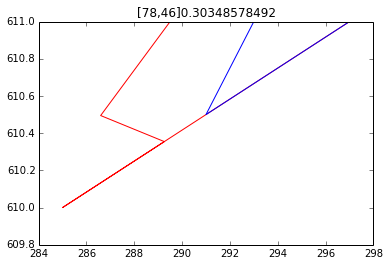

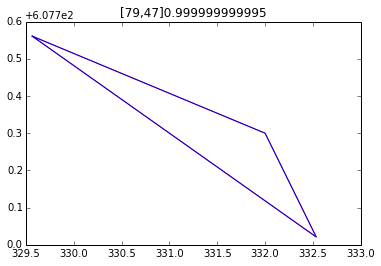

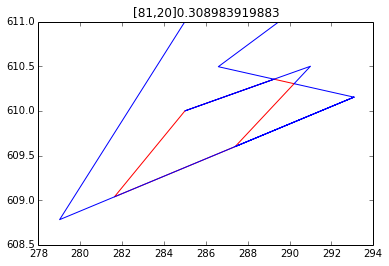

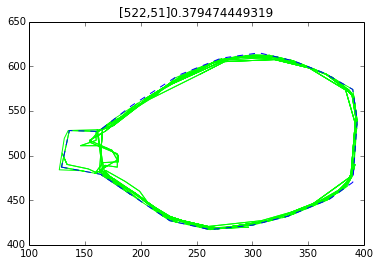

In [193]:
import copy
objid=33
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
    
tiles = BB2TileExact(objid,BB)
unique_tiles = compute_unique_tileset(tiles)
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
p,r=PR_compare(objid,tiles,sampleNworkers=-1)